In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

#Sonnenaufgang/Sonnenuntergang laden und Tagesstunden berechnen
df["tagesstunden"] = round((pd.to_timedelta(
    pd.to_datetime(df["sonnenuntergang"]).dt.strftime("%H:%M:%S")).dt.total_seconds() - 
    pd.to_timedelta(pd.to_datetime(df["sonnenaufgang"]).dt.strftime("%H:%M:%S")).dt.total_seconds()) / 3600, 1)

df = df.drop(["sonnenaufgang", "sonnenuntergang"], axis=1)

#Niederschlag laden
df_ = pd.read_csv("Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True, usecols=[0,2])
df_ = df_.join(pd.read_csv("Datenbeschaffung/stuttgart.csv", index_col=0, parse_dates=True, usecols=[0,10], squeeze=True).rename("stuttgart"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/freiburg.csv", index_col=0, parse_dates=True, usecols=[0,10], squeeze=True).rename("freiburg"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/mannheim.csv", index_col=0, parse_dates=True, usecols=[0,10], squeeze=True).rename("mannheim"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/ulm.csv", index_col=0, parse_dates=True, usecols=[0,10], squeeze=True).rename("ulm"))

#Durchschnitt berechnen
df["niederschlag"] = round(((df_["stuttgart"] + df_["freiburg"] + df_["mannheim"] + df_["ulm"]) / 4), 1)

#Temporär für Analysen verwendete Spalten erstellen
df["niederschlag_gerundet"] = round(df["niederschlag"],0)
df["niederschlag_gruppiert"] = 5 * round(df["niederschlag"]/5)

#Indikator für Regen erstellen
df["regen"] = np.where(df["niederschlag"] < 0.5, 1, 0)

#Aufteilung in zwei DataFrames für weitere Analysen
df_arbeitstag = df[df["arbeitstag"] == 1]
df_arbeitsfreiertag = df[df["arbeitstag"] == 0]

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag  arbeitstag  temperatur  tagesstunden  niederschlag  niederschlag_gerundet  niederschlag_gruppiert  regen
datum                                                                                                                                                
2015-01-01     126197    Januar  Donnerstag           0        -2.5           8.4           0.0                    0.0                     0.0      1
2015-01-02     147085    Januar     Freitag           1        -0.0           8.4           5.6                    6.0                     5.0      0
2015-01-03     141426    Januar     Samstag           0         1.2           8.4          14.1                   14.0                    15.0      0
2015-01-04     132446    Januar     Sonntag           0        -0.2           8.4           4.4                    4.0                     5.0      0
2015-01-05     152611    Januar      Montag           1        -0.5           8.4           0.0     

# <font size="7">Datenanalyse</font>

<font size="5">Der Niederschlag reicht von 0 bis etwa 35 mm/m², an wenigen Tagen liegt der Niederschlag allerdings auch bei höheren Werten von bis zu 58 mm/m². Anders als bei den bisherigen Merkmalen nimmt der Niederschlag allerdings auch häufig Werte von 0 (oder fast 0) an, da es an vielen Tagen nicht regnet. Es ist zunächst etwas schwerer erkennbar, allerdings folgt der Niederschlag wie schon bei der Analyse der Wetterbeschreibung einer jährlichen Saisonalität, im Rahmen derer er sein Maximum Mitte des Jahres im Sommer erreicht und sich in den kalten Wintermonaten seinem Minimum annähert. Diese Saisonalität ist allerdings eher schwächer ausgeprägt und wird allgemein durch die vielen Tage ohne Niederschlag gestört.</font>

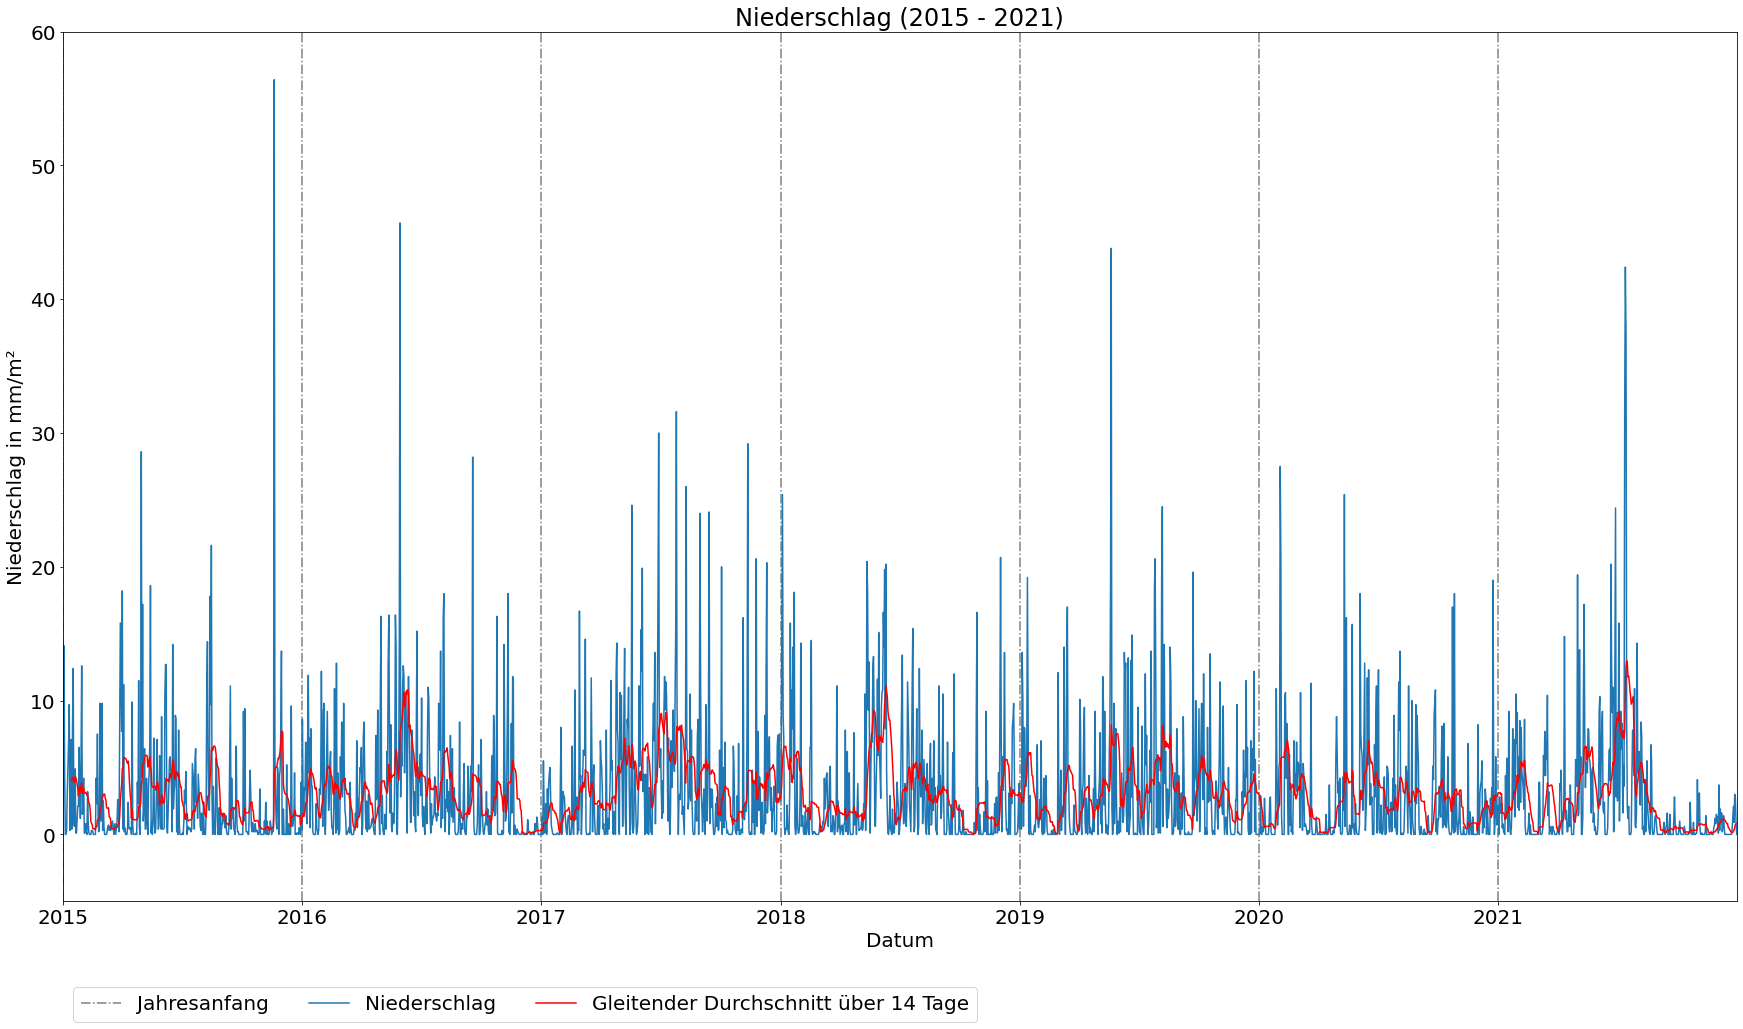

In [3]:
functions.draw_years(df)

#Niederschlag plotten
plt.plot(df["niederschlag"], label="Niederschlag");
plt.plot(df["niederschlag"].rolling(window=14).mean(), color="red", label="Gleitender Durchschnitt über 14 Tage")

#Achsen und Layout
plt.title("Niederschlag (2015 - 2021)")
plt.ylabel("Niederschlag in mm/m²")
plt.ylim(-5, 60)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

plt.show()

<font size="5">Die jährliche Saisonalität zeigt sich auch bei den Boxplots. Hier ist noch einmal erkennbar, dass die Saisonalität eher gering ausgeprägt ist. Teilweise ist der Anstieg des Niederschlags in den warmen Sommermonaten nicht nur darauf zurückzuführen, dass der Niederschlag an Regentagen größer ist, sondern auch auf die Tatsache, dass es in diesem Zeitraum öfter zu Regen kommt als im Winter. Dadurch sind bei der Berechnung des Durchschnitts weniger Tage mit 0 eingerechnet.</font>

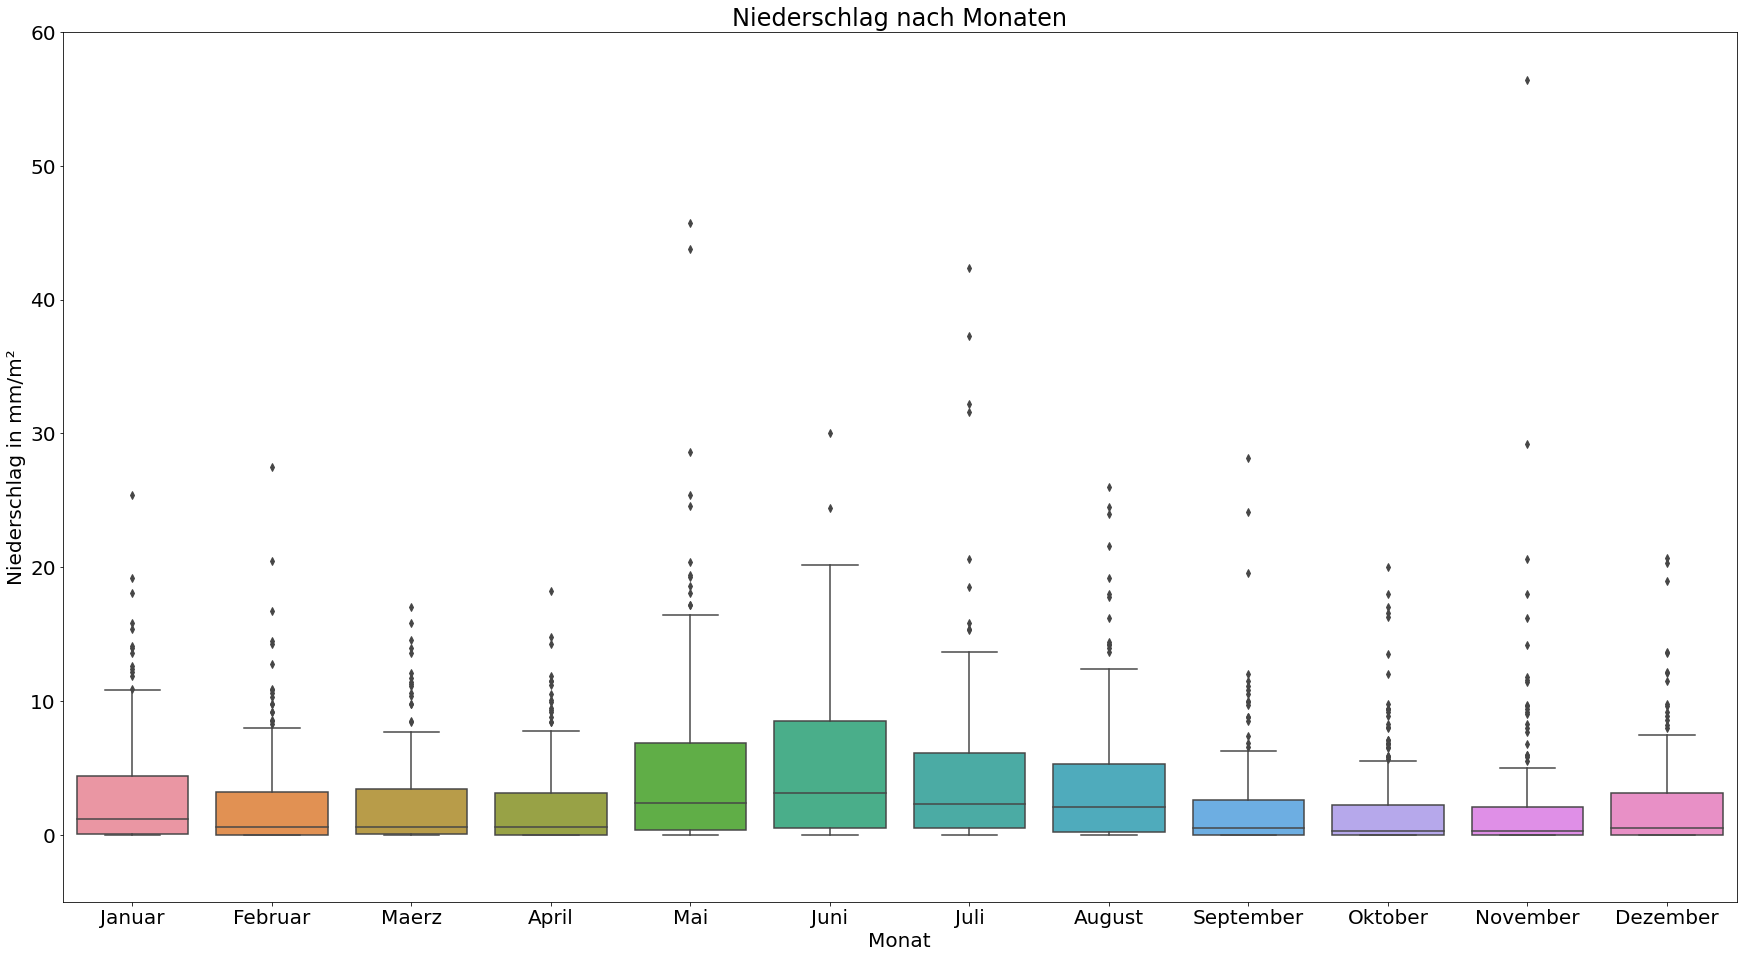

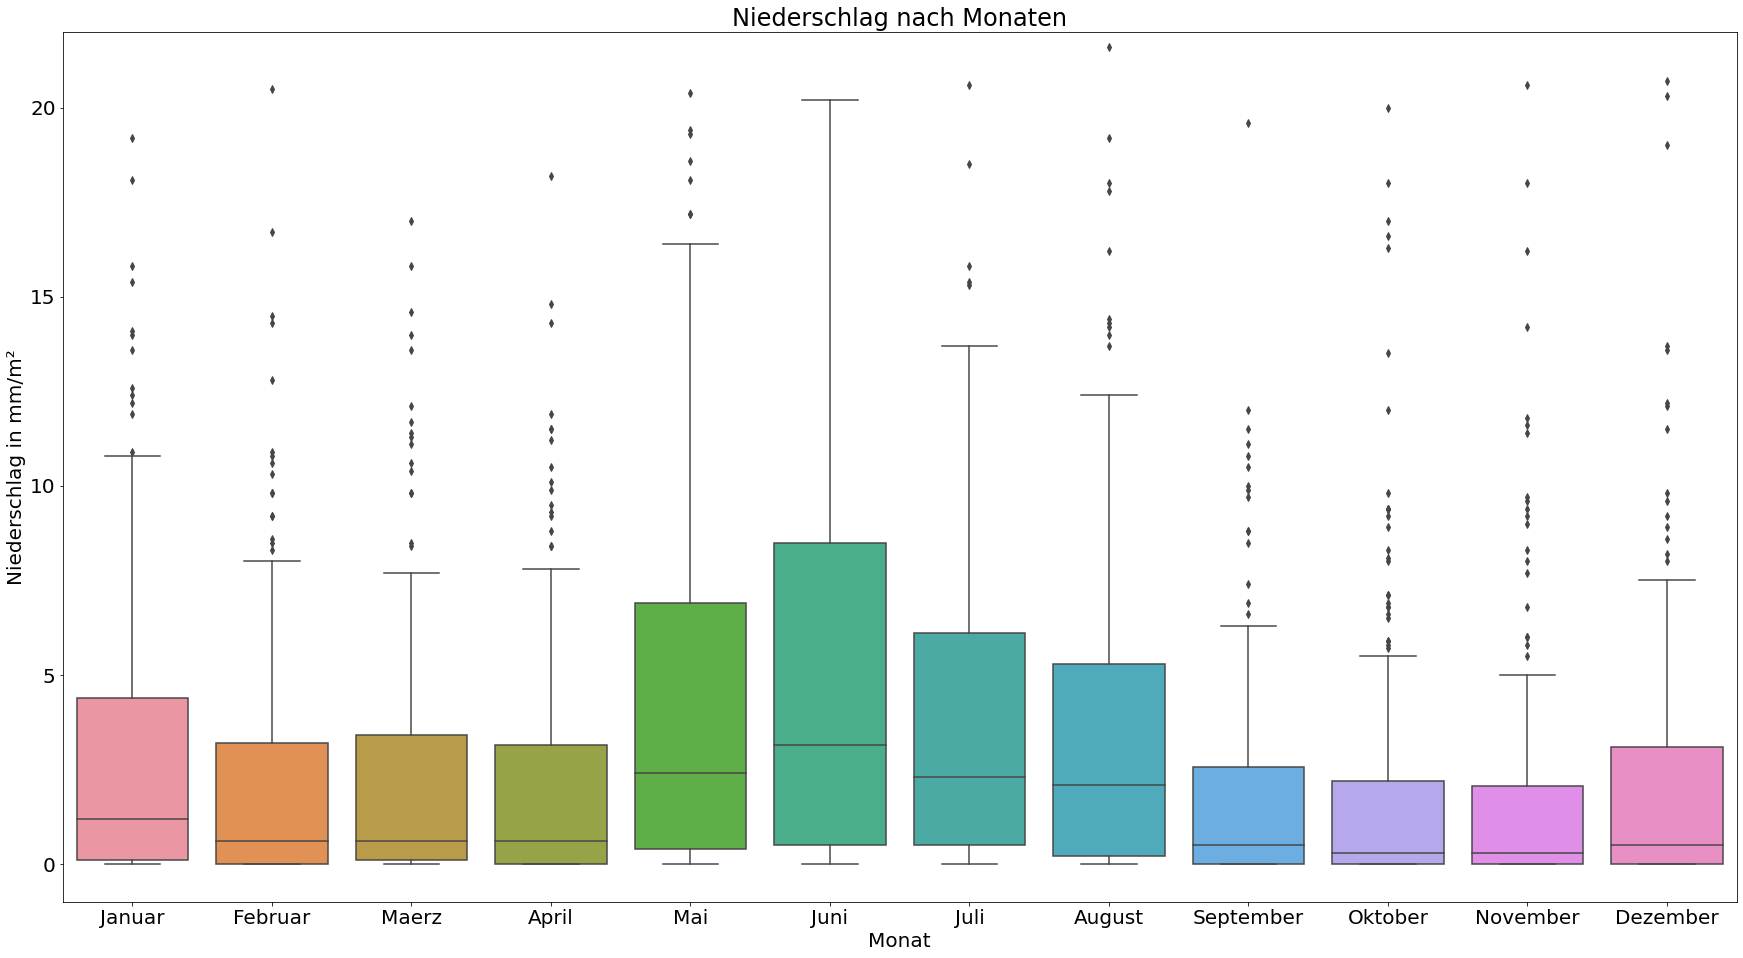

In [4]:
#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="niederschlag")

#Achsen und Layout
plt.title("Niederschlag nach Monaten")
plt.ylabel("Niederschlag in mm/m²")
plt.ylim(-5, 60)
plt.xlabel("Monat")

plt.show()

#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="niederschlag")

#Achsen und Layout
plt.title("Niederschlag nach Monaten")
plt.ylabel("Niederschlag in mm/m²")
plt.ylim(-1, 22)
plt.xlabel("Monat")

plt.show()

<font size="5">Das Histogramm zeigt eine deutliche rechtsschiefe Verteilung in den Daten. An den meisten Tagen kommt es zu keinem Niederschlag. An Tagen mit Niederschlag liegen die Werte meisten bei unter 10 mm/m². Werte über 21 mm/m² sind äußerst selten.</font>

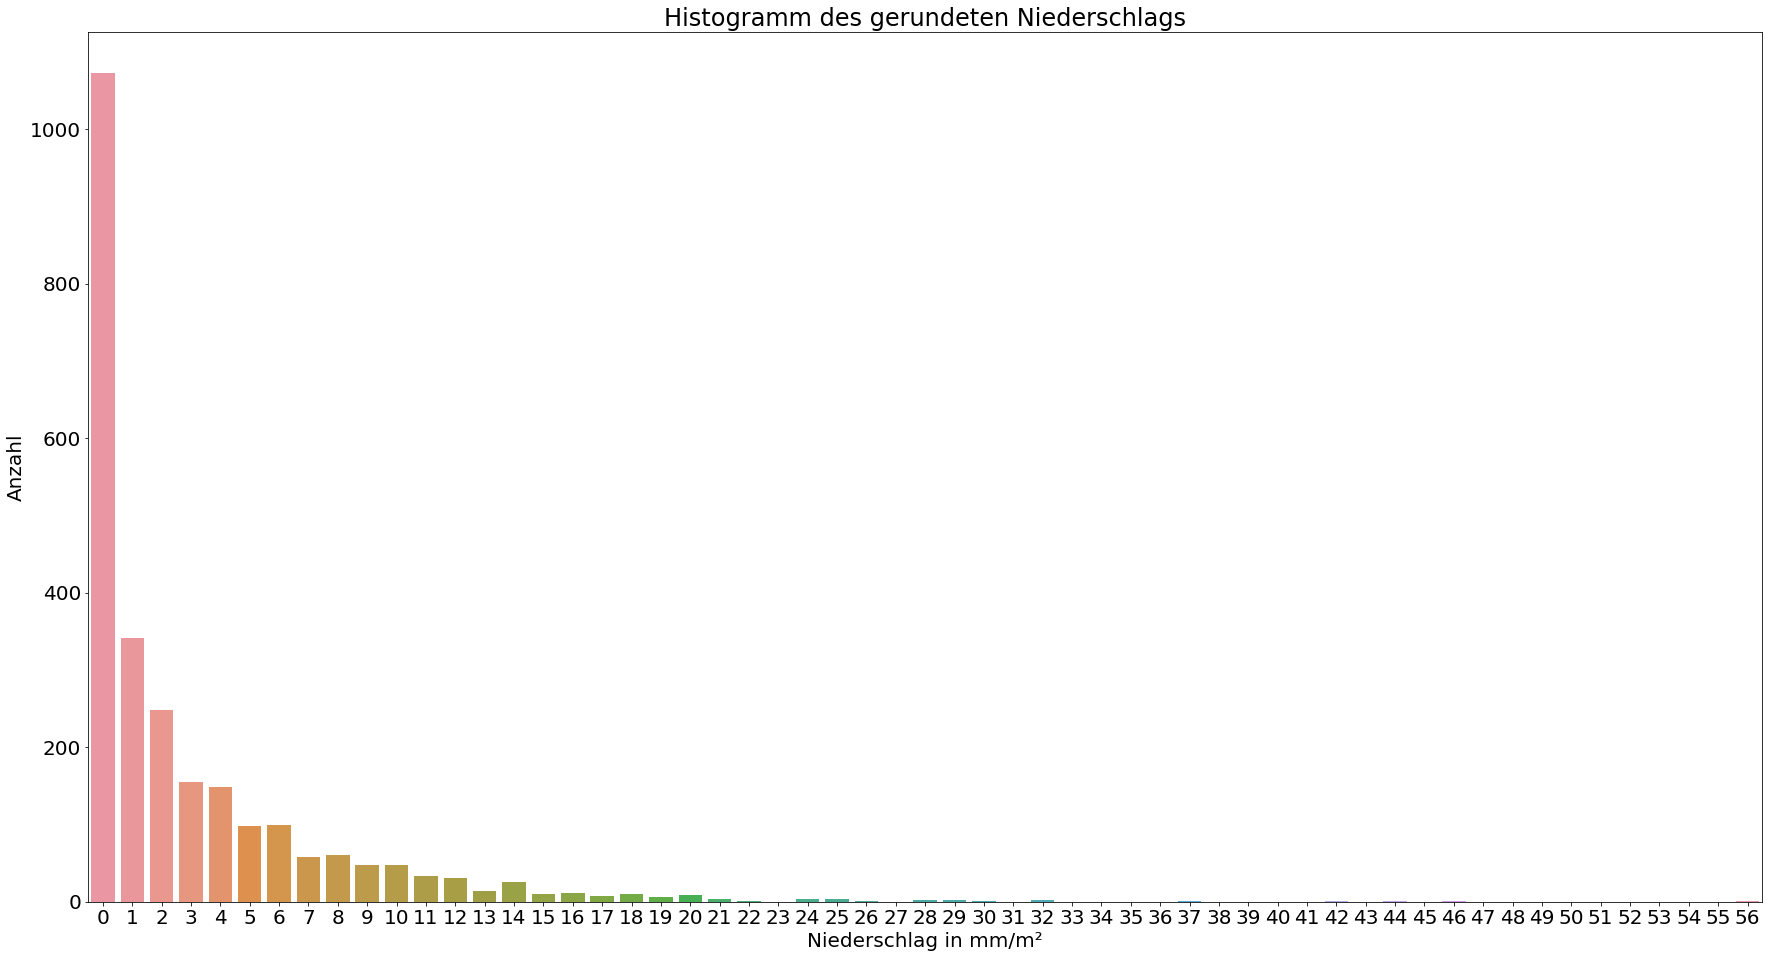

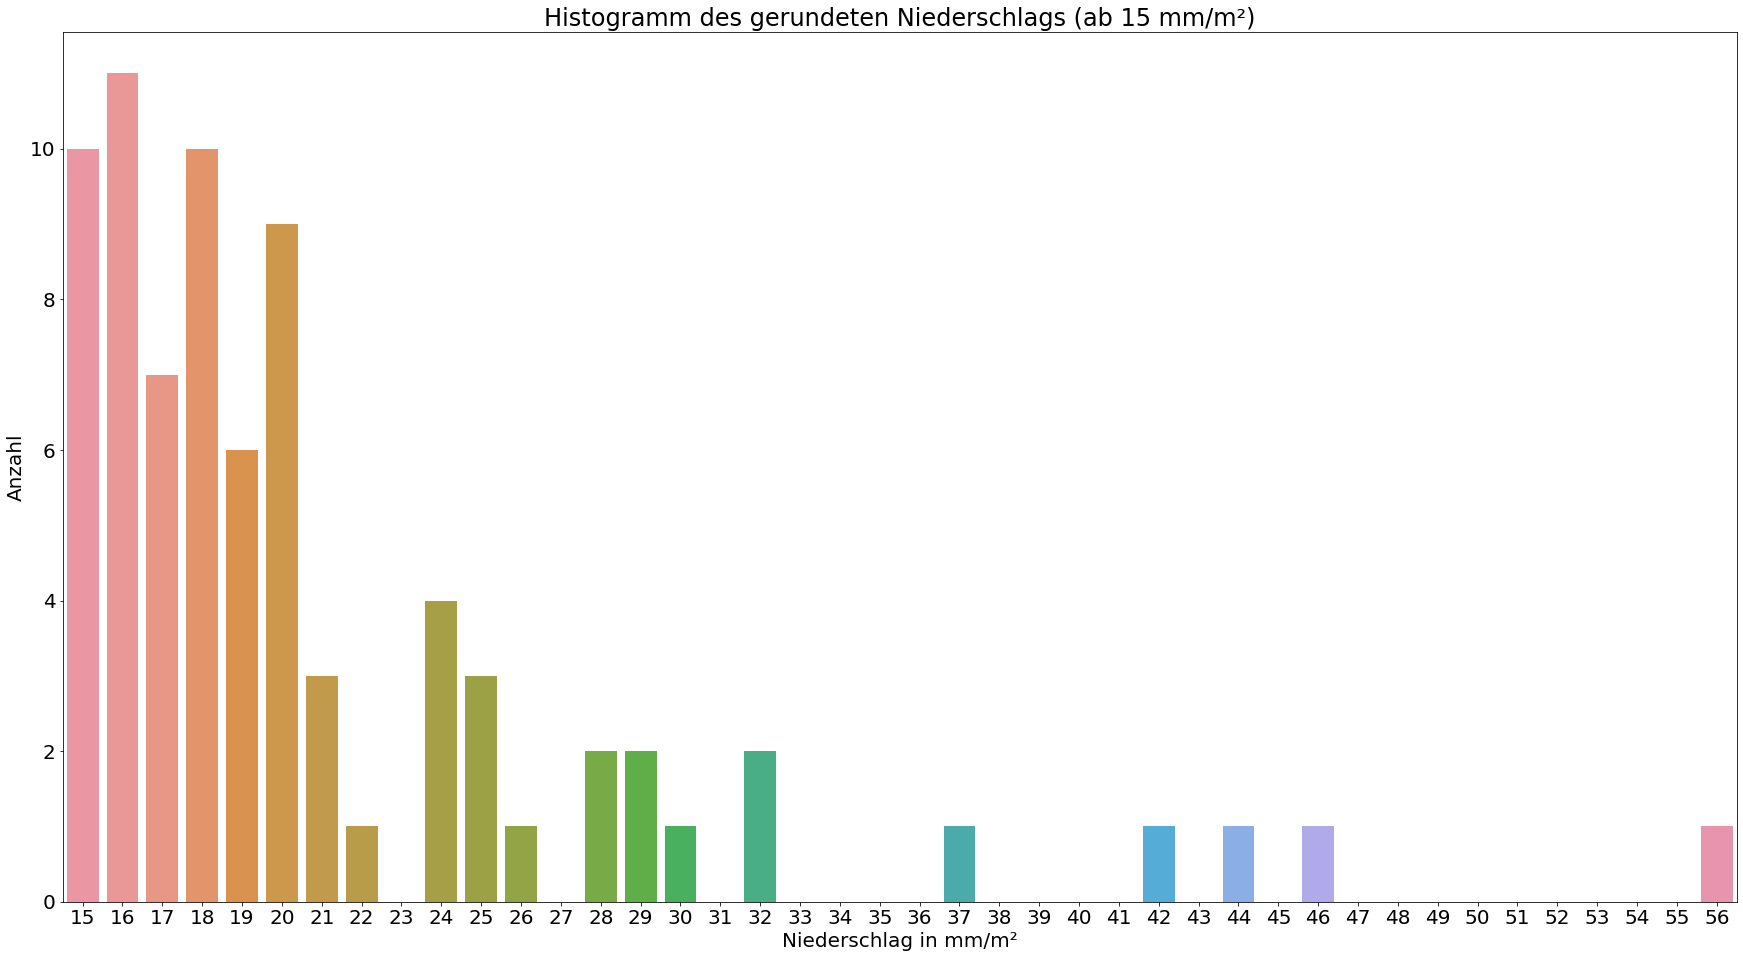

In [5]:
#Histogramm erstellen
sns.countplot(df["niederschlag_gerundet"], order=np.arange(0, 57, 1))

#Achsen und Layout
plt.title("Histogramm des gerundeten Niederschlags")
plt.ylabel("Anzahl")
plt.xlabel("Niederschlag in mm/m²")

plt.show()

#Histogramm erstellen
sns.countplot(df[df["niederschlag_gerundet"] >= 15]["niederschlag_gerundet"], order=np.arange(15, 57, 1))

#Achsen und Layout
plt.title("Histogramm des gerundeten Niederschlags (ab 15 mm/m²)")
plt.ylabel("Anzahl")
plt.xlabel("Niederschlag in mm/m²")

plt.show()

## <font size="6">Korrelationsanalyse</font>

### <font size="5">Liniendiagramm (Verlauf)</font>

<font size="5">Beim Verlauf des Niederschlags und des Stromverbrauchs lässt sich nur bedingt ein Zusammenhang erkennen. Zwar steigen Stromverbrauch und Niederschlag in den besonders warmen Sommermonaten vermeintlich gemeinsam an, im übrigen Jahr lässt sich allerdings kein Zusammenhang erkennen. Betrachtet man die gleitenden Durchschnitte ist erkennbar, dass der Anstieg von Stromverbrauch und Niederschlag an vielen Stellen sehr asynchron ist (beispielsweise in den Jahr 2016 und 2018). Einen synchronen Anstieg gibt es nur im Jahr 2021, dieser scheint jedoch eher zufällig zu sein. Insgesamt lässt sich kein Zusammenhang zwischen den Verläufen der beiden Merkmale erkennen.</font>

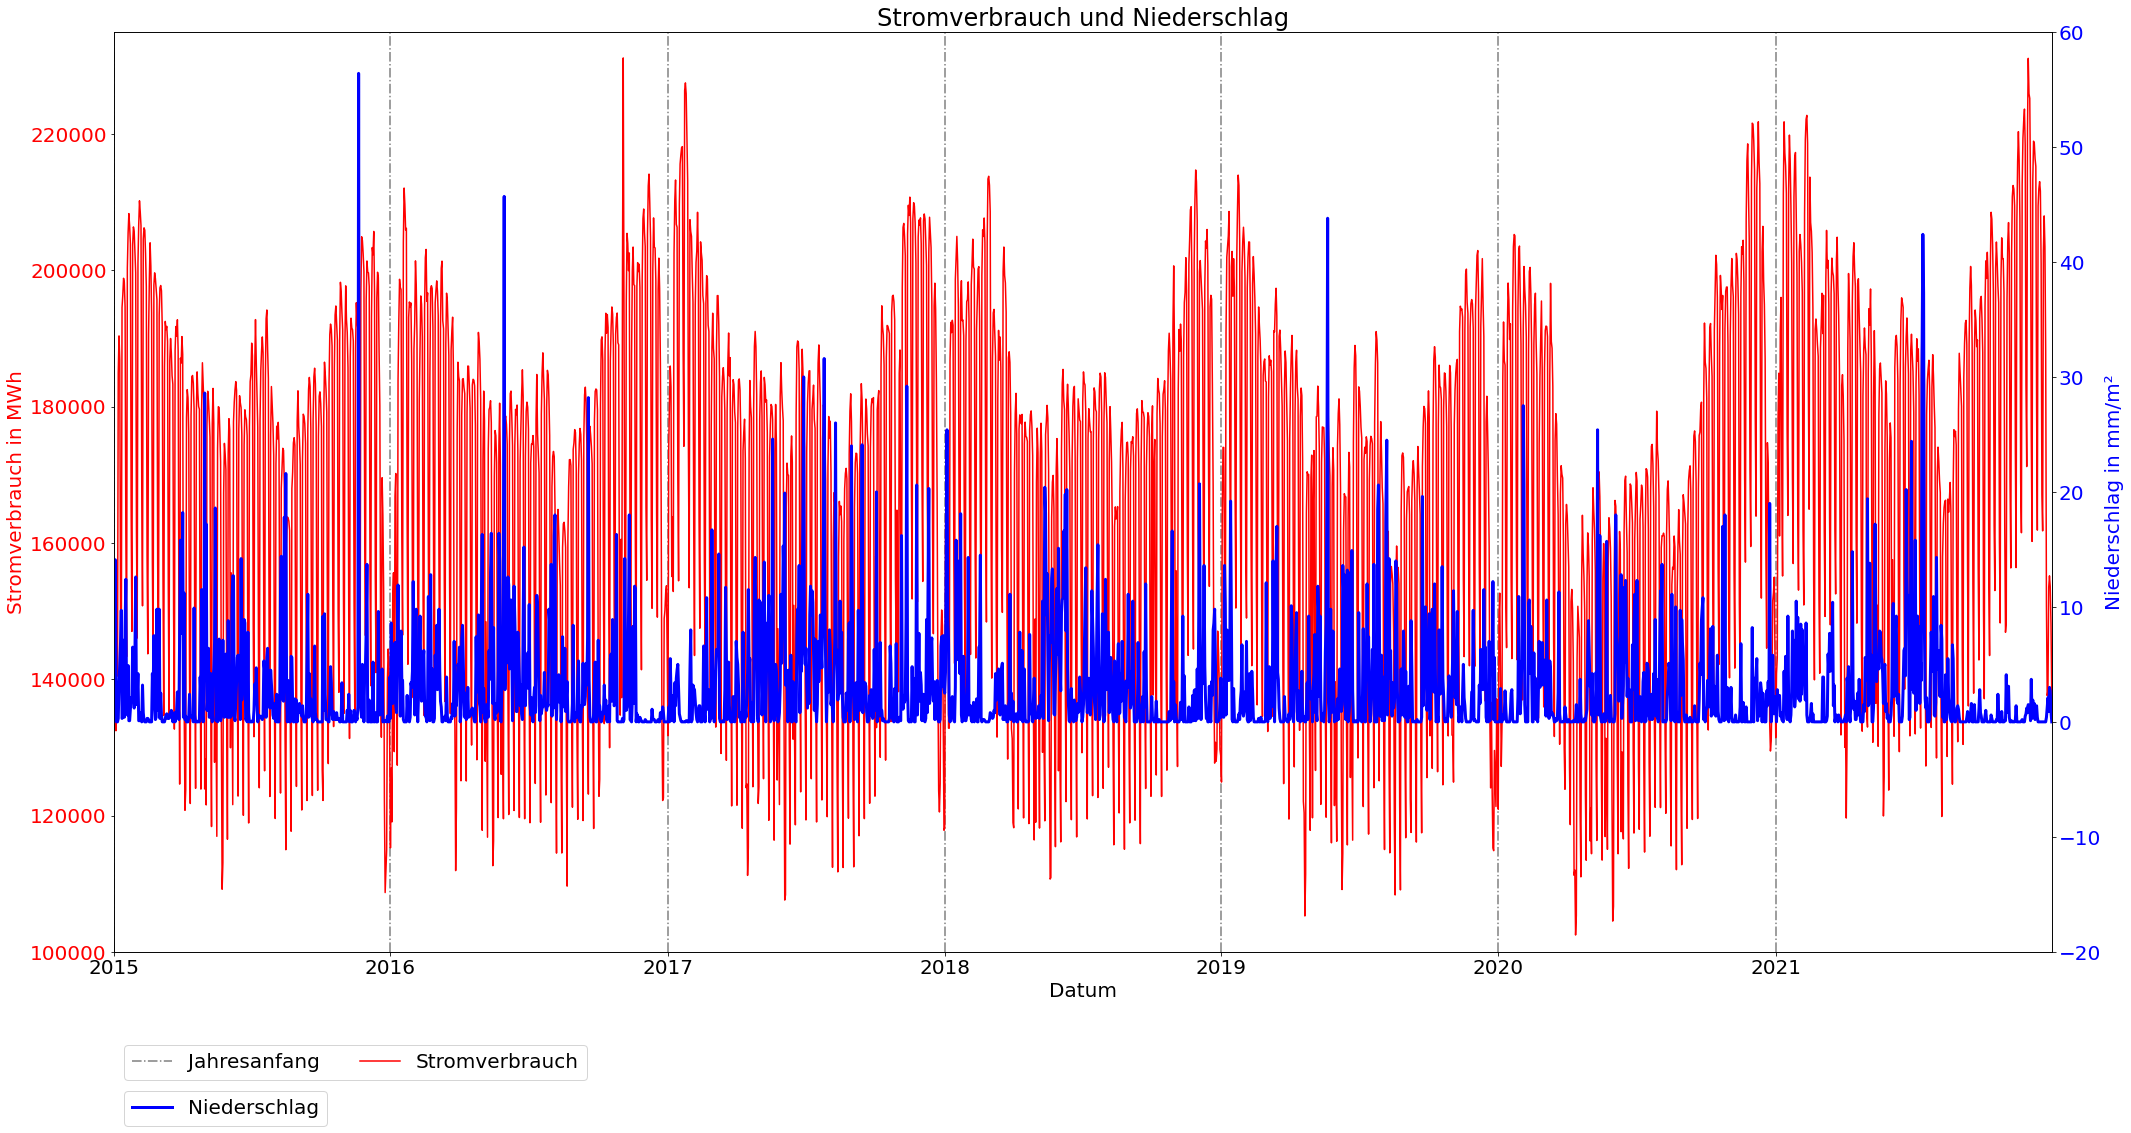

Pearson :
p-Wert von 0.004 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.057
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.086
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.059





In [6]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Stromverbrauch und Niederschlag")

#Verbrauch plotten
ax1.plot(df["verbrauch"], color="red", label="Stromverbrauch")
#Achsen und Layout
ax1.set_ylabel("Stromverbrauch in MWh", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(100000,235000)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Luftfeuchtigkeit plotten
ax2.plot(df["niederschlag"], color="blue", linewidth=3, label="Niederschlag")
#Achsen und Layout
ax2.set_ylabel("Niederschlag in mm/m²", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(-20, 60)
ax2.set_xlabel("Datum")
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["niederschlag"], df["verbrauch"])
print("\n\n")



 Gleitender Durchschnitt über 3  Tage----------------------------------------------------------------------------------------------------------------------------------------------




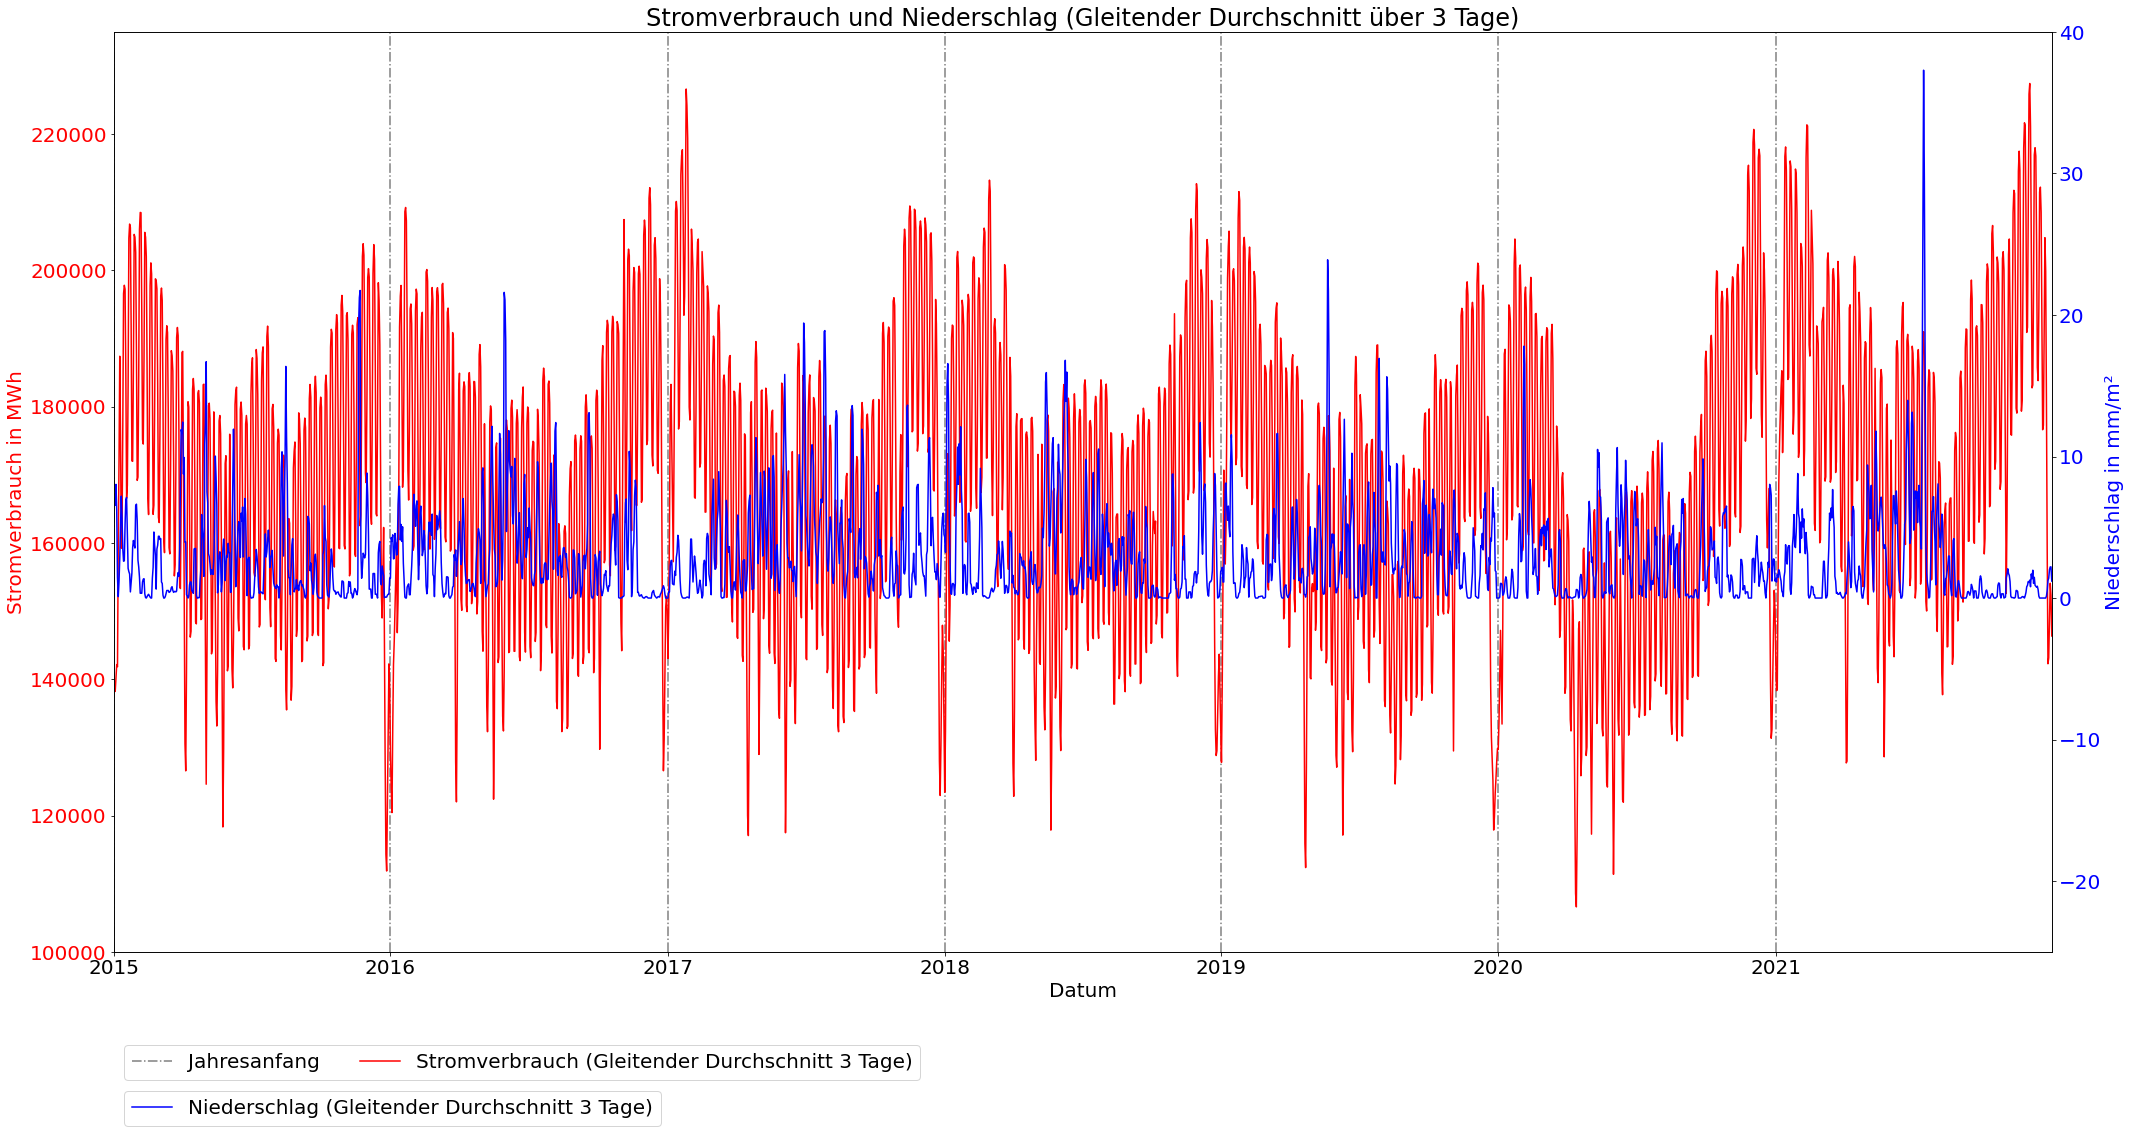

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.104
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.138
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.092





 Gleitender Durchschnitt über 7  Tage----------------------------------------------------------------------------------------------------------------------------------------------




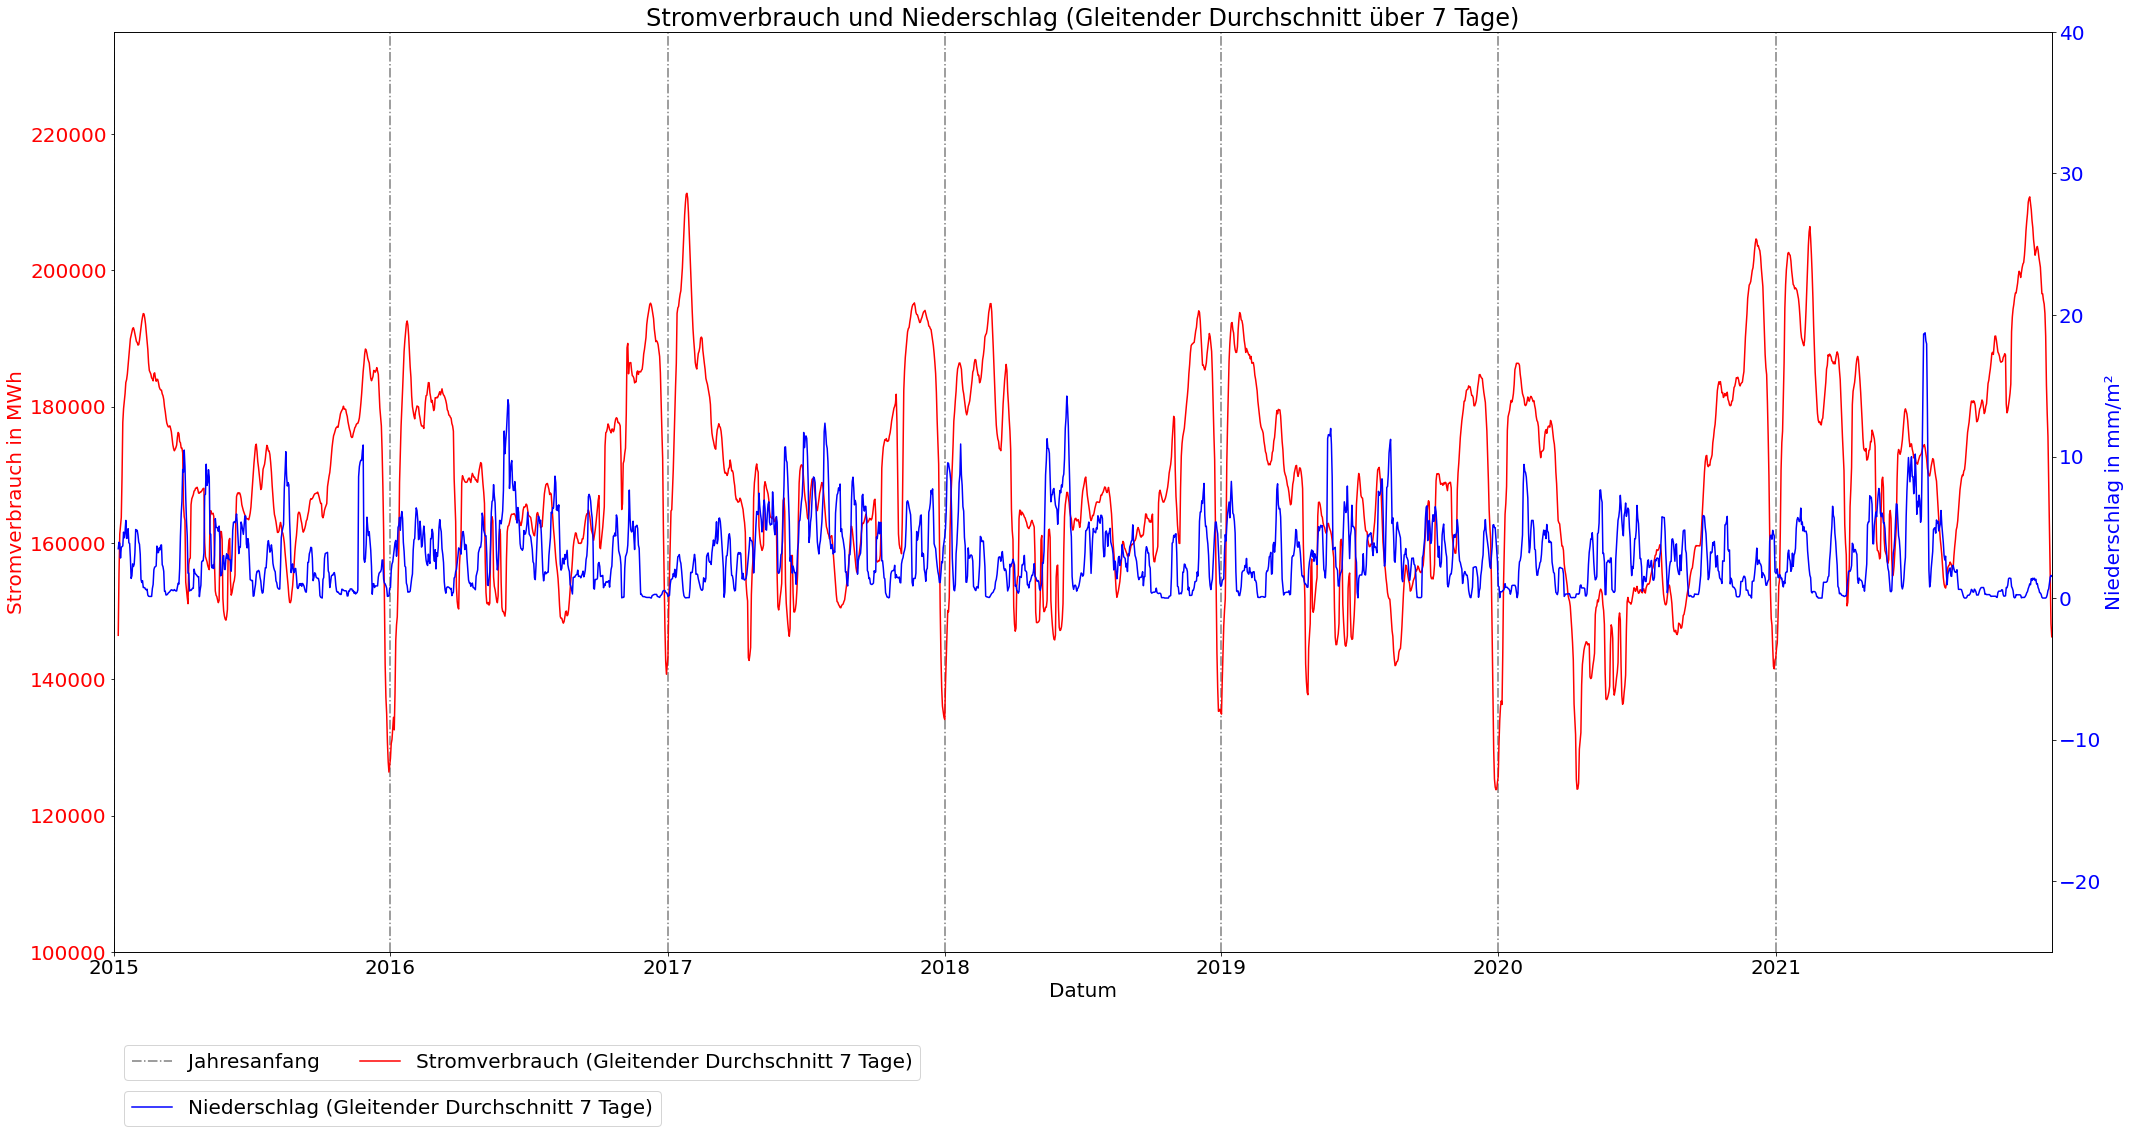

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.167
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.206
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.138





 Gleitender Durchschnitt über 14  Tage----------------------------------------------------------------------------------------------------------------------------------------------




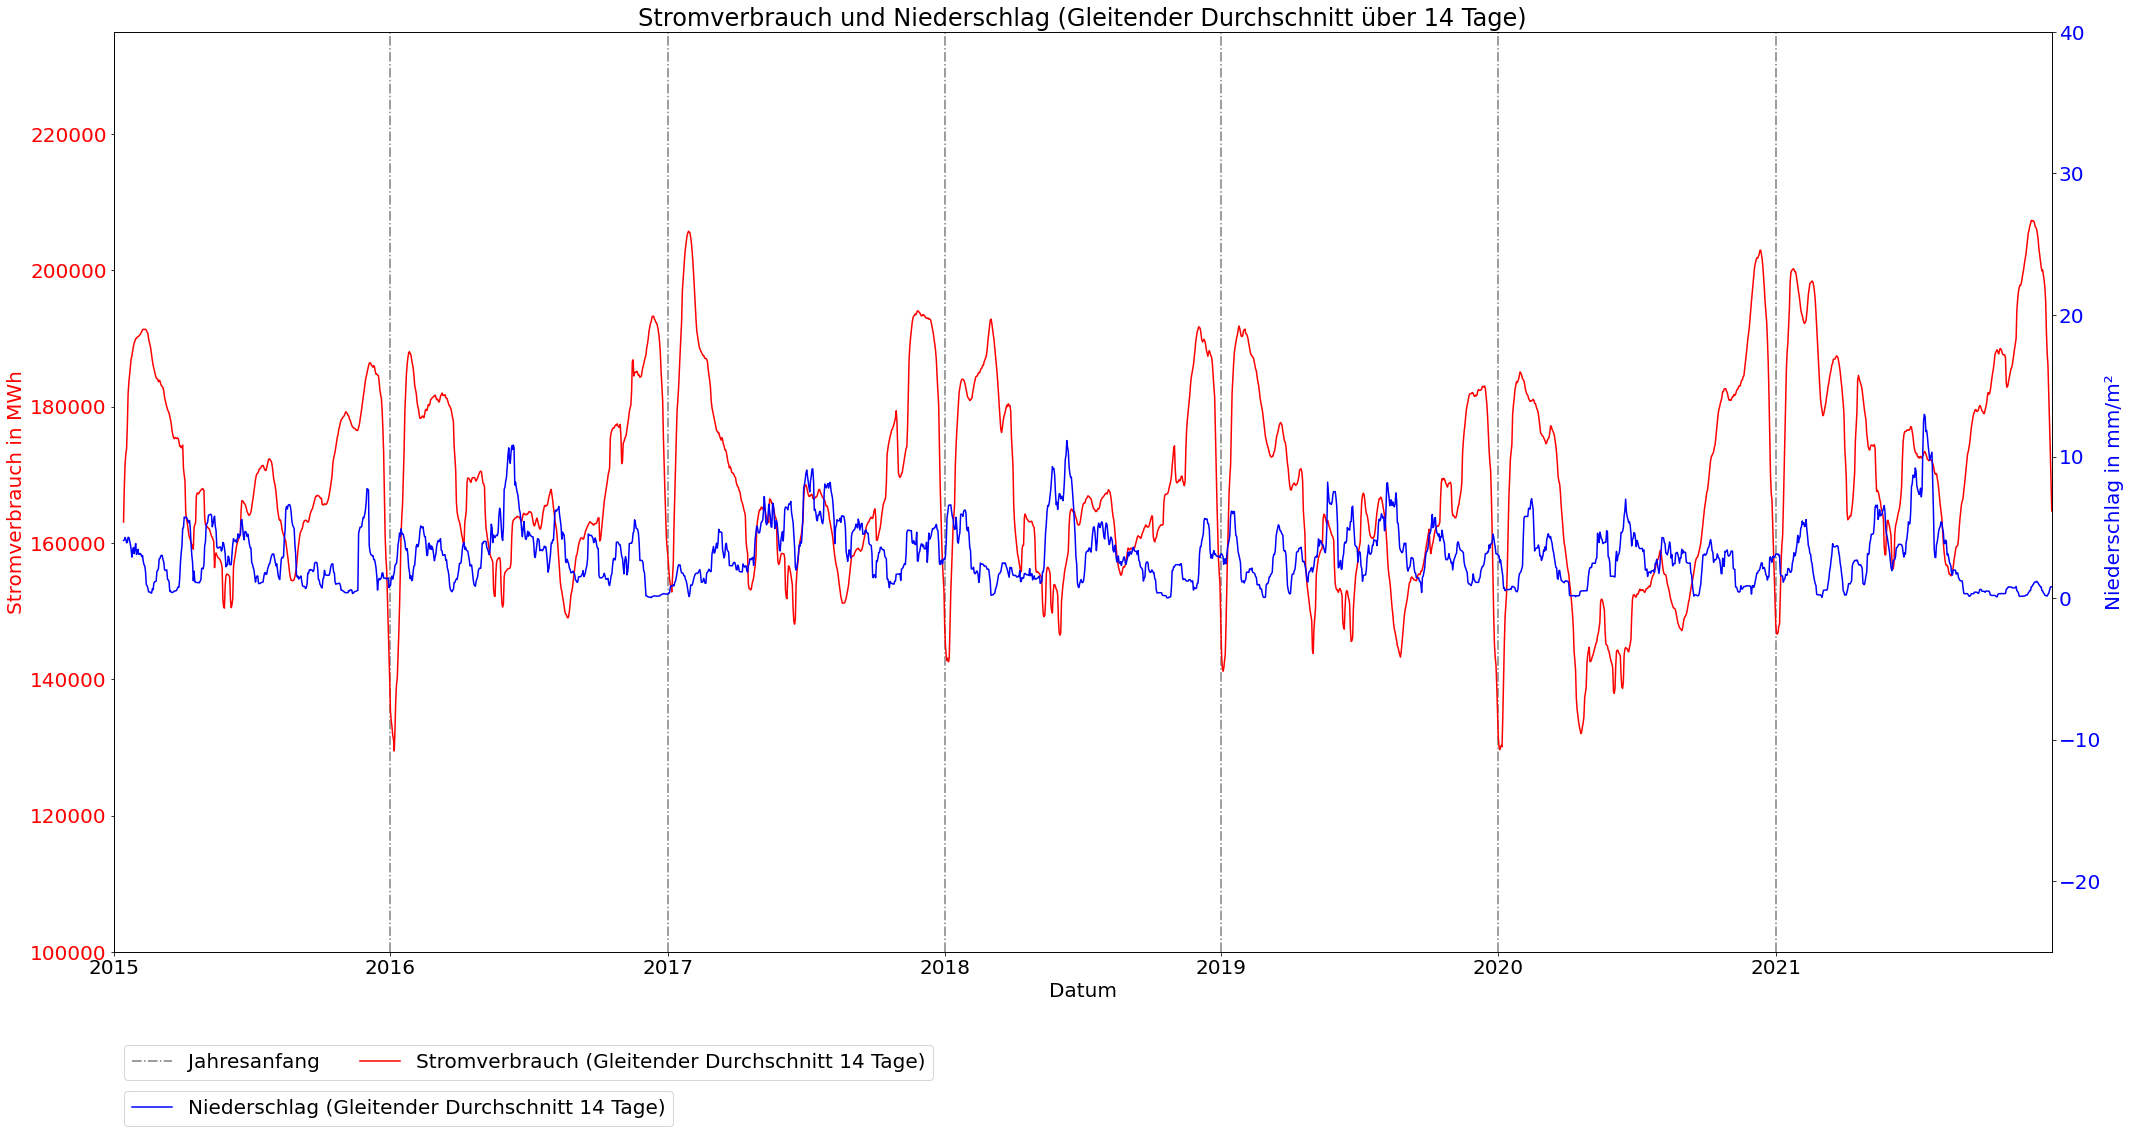

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.236
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.263
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.176





 Gleitender Durchschnitt über 28  Tage----------------------------------------------------------------------------------------------------------------------------------------------




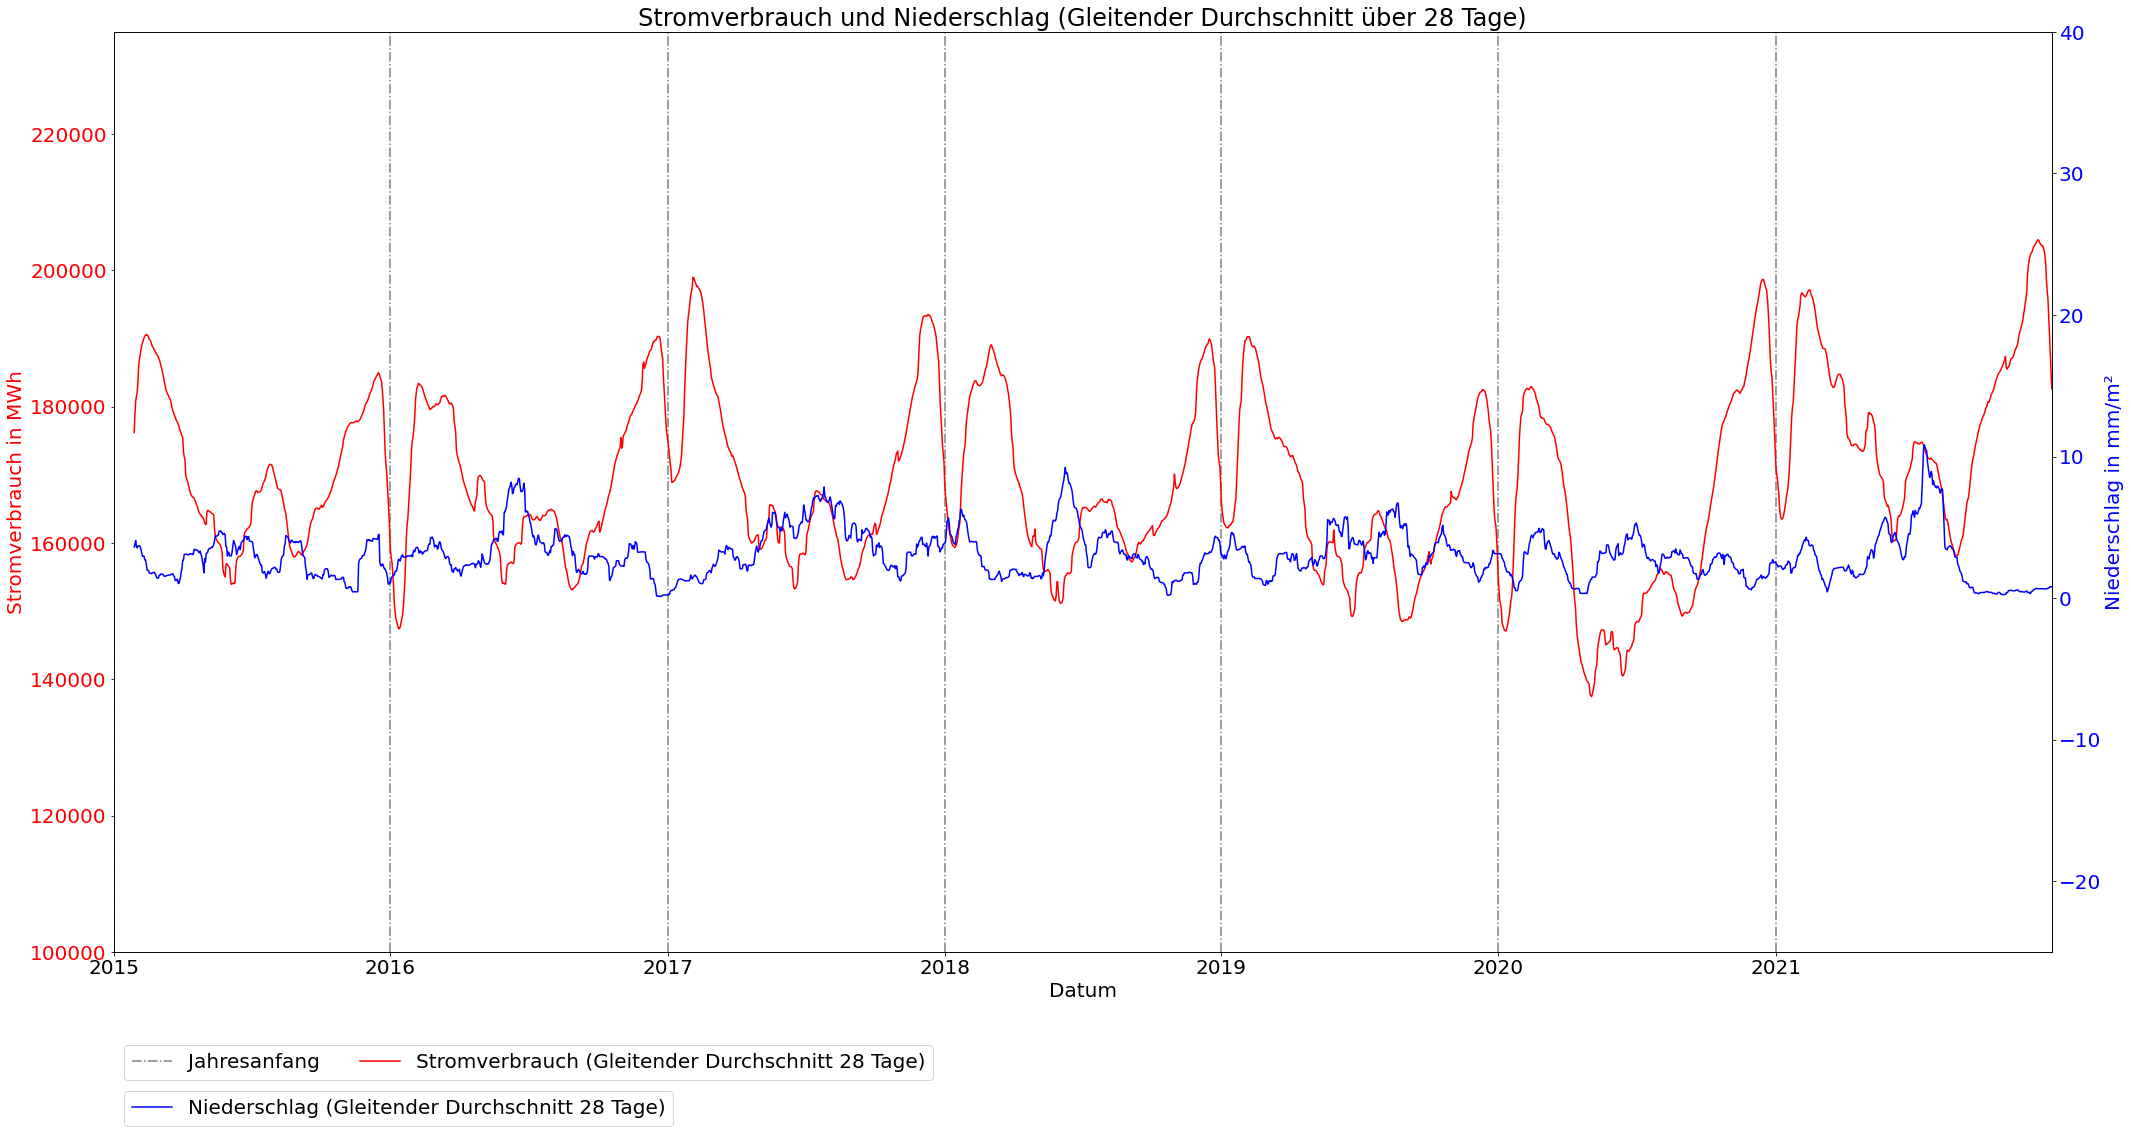

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.324
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.354
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.239





In [7]:
#Durchlaufen verschiedener gleitender Durchschnitte
for window in [3, 7, 14, 28]:

    print("\n\n", "Gleitender Durchschnitt über", window," Tage----------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    fig, ax1 = plt.subplots()

    functions.draw_years(df)

    ax1.set_title("Stromverbrauch und Niederschlag (Gleitender Durchschnitt über " + str(window) + " Tage)")
    
    #Gleitenden Durchschnitt des Verbrauchs plotten
    ax1.plot(df["verbrauch"].rolling(window=window).mean(), color="red", label="Stromverbrauch (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax1.set_ylabel("Stromverbrauch in MWh", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(100000,235000)
    ax1.set_xlabel("Datum")
    ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)
    
    #Gleitenden Durchschnitt der Temperatur plotten
    ax2 = ax1.twinx()
    ax2.plot(df["niederschlag"].rolling(window=window).mean(), color="blue", label="Niederschlag (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax2.set_ylabel("Niederschlag in mm/m²", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(-25, 40)
    ax2.set_xlabel("Datum")
    ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

    plt.tight_layout()
    plt.show()

    #Korrelationskoeffizienten ausgeben
    functions.correlation_coefficients(df["niederschlag"].rolling(window=window).mean().dropna(), df["verbrauch"].rolling(window=window).mean().dropna())
    print("\n\n")

## <font size="6">Stromverbrauch nach Niederschlag (Scatterplot)</font>

<font size="5">Im Scatterplot lässt sich kein Zusammenhang von Niederschlag und Stromverbrauch erkennen. Auch die Regressionsfunktion kann keinen Zusammenhang ermitteln und ist daher fast waagerecht.</font>

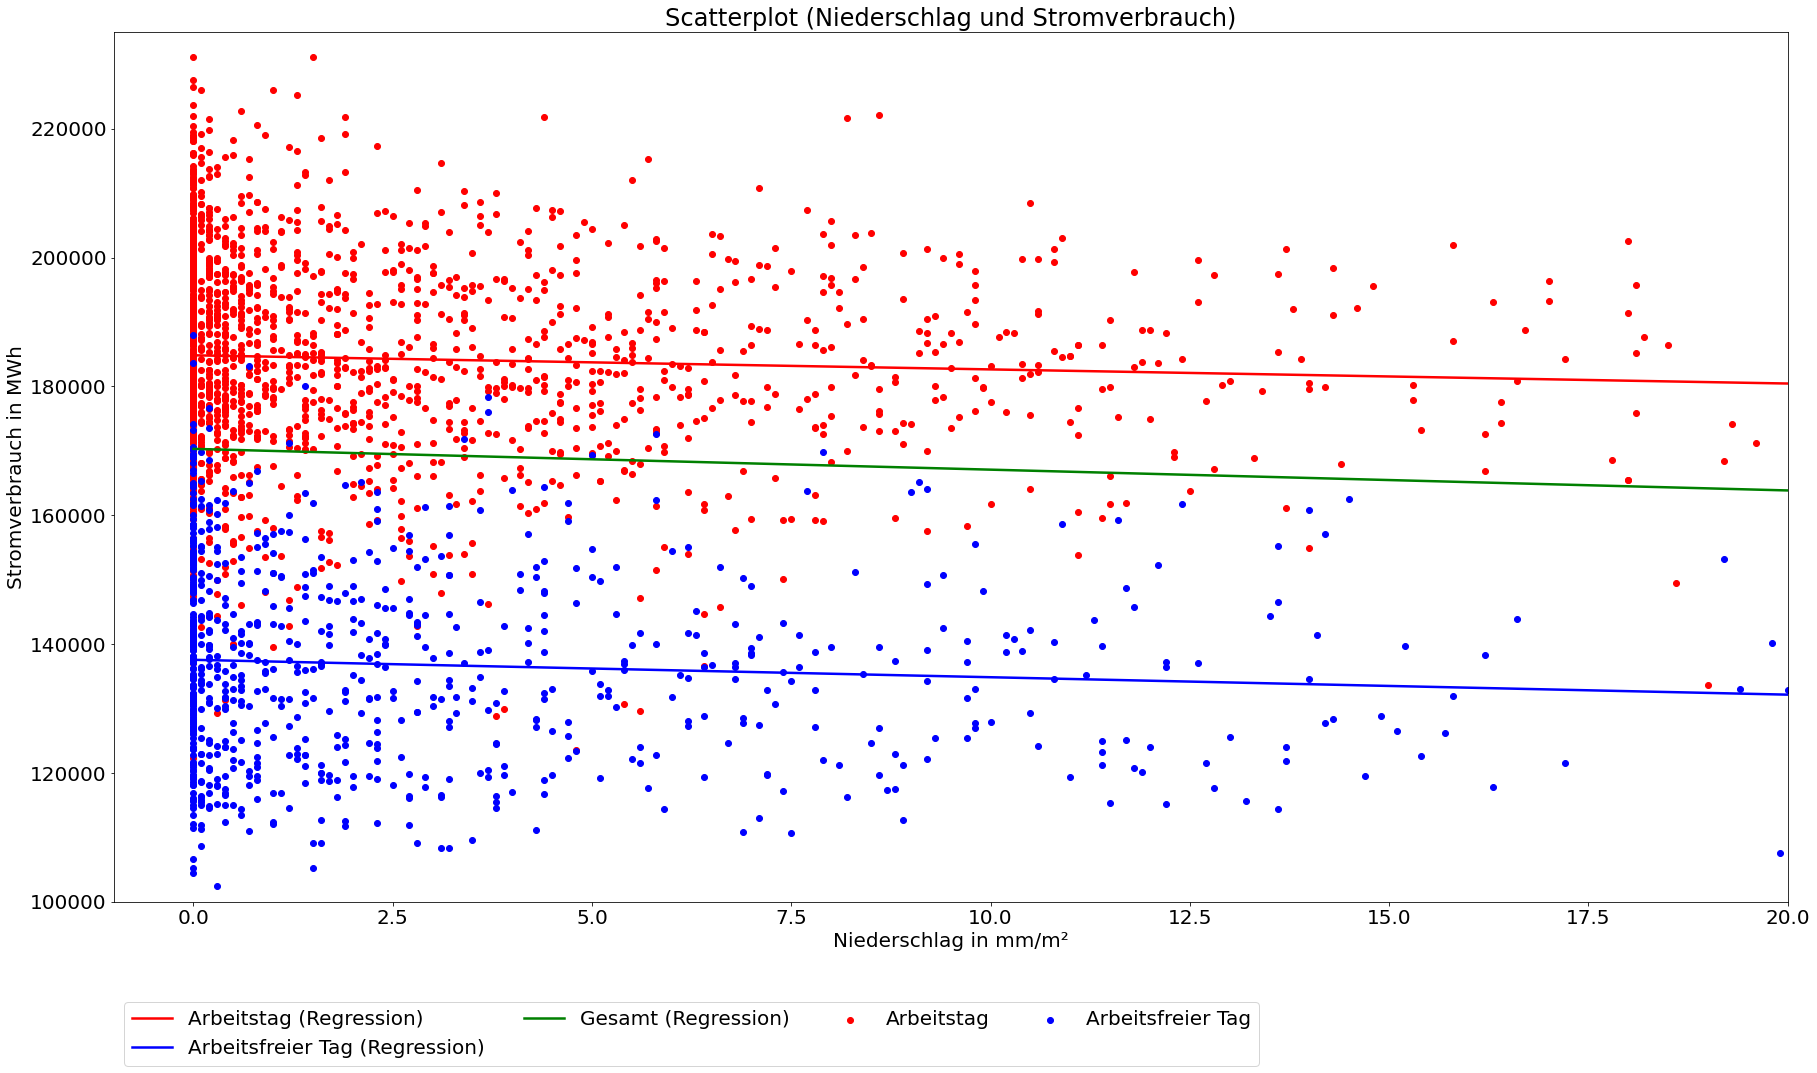

Arbeitstage
Pearson :
p-Wert von 0.005 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.067
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.093
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.064


Arbeitsfreie Tage
Pearson :
p-Wert von 0.026 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.079
Spearman :
p-Wert von 0.007 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.096
Kendall :
p-Wert von 0.007 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.065


In [8]:
x = range(0, 40, 1)

#Niederschlag und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag["niederschlag"], df_arbeitstag["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag["niederschlag"], df_arbeitstag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Niederschlag und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag["niederschlag"], df_arbeitsfreiertag["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag["niederschlag"], df_arbeitsfreiertag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["niederschlag"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Scatterplot (Niederschlag und Stromverbrauch)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Niederschlag in mm/m²")
plt.xlim(-1, 20)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag["niederschlag"], df_arbeitstag["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag["niederschlag"], df_arbeitsfreiertag["verbrauch"])

## <font size="6">Stromverbrauch nach Niederschlag (Boxplot)</font><a class="anchor" id="2-06b-verbrauchnachgerundetemniederschlag"></a>

<font size="5">Die Boxplots lassen ebenfalls keinen Zusammenhang erkennen.</font>

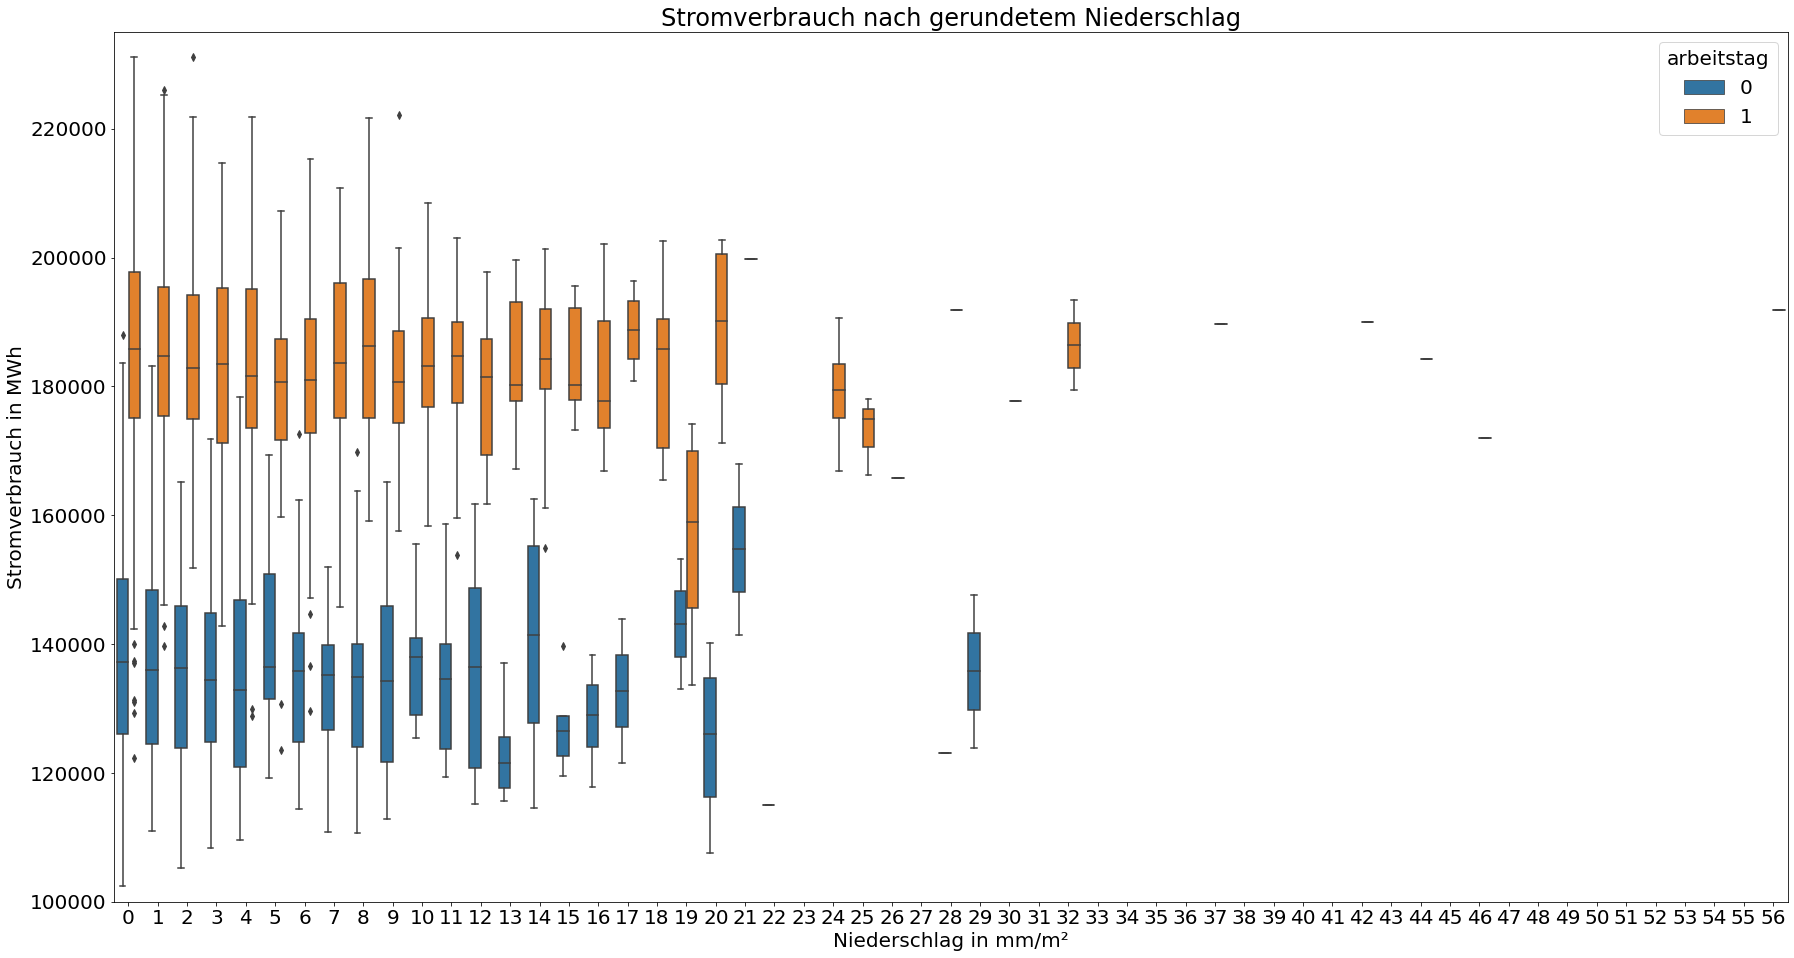

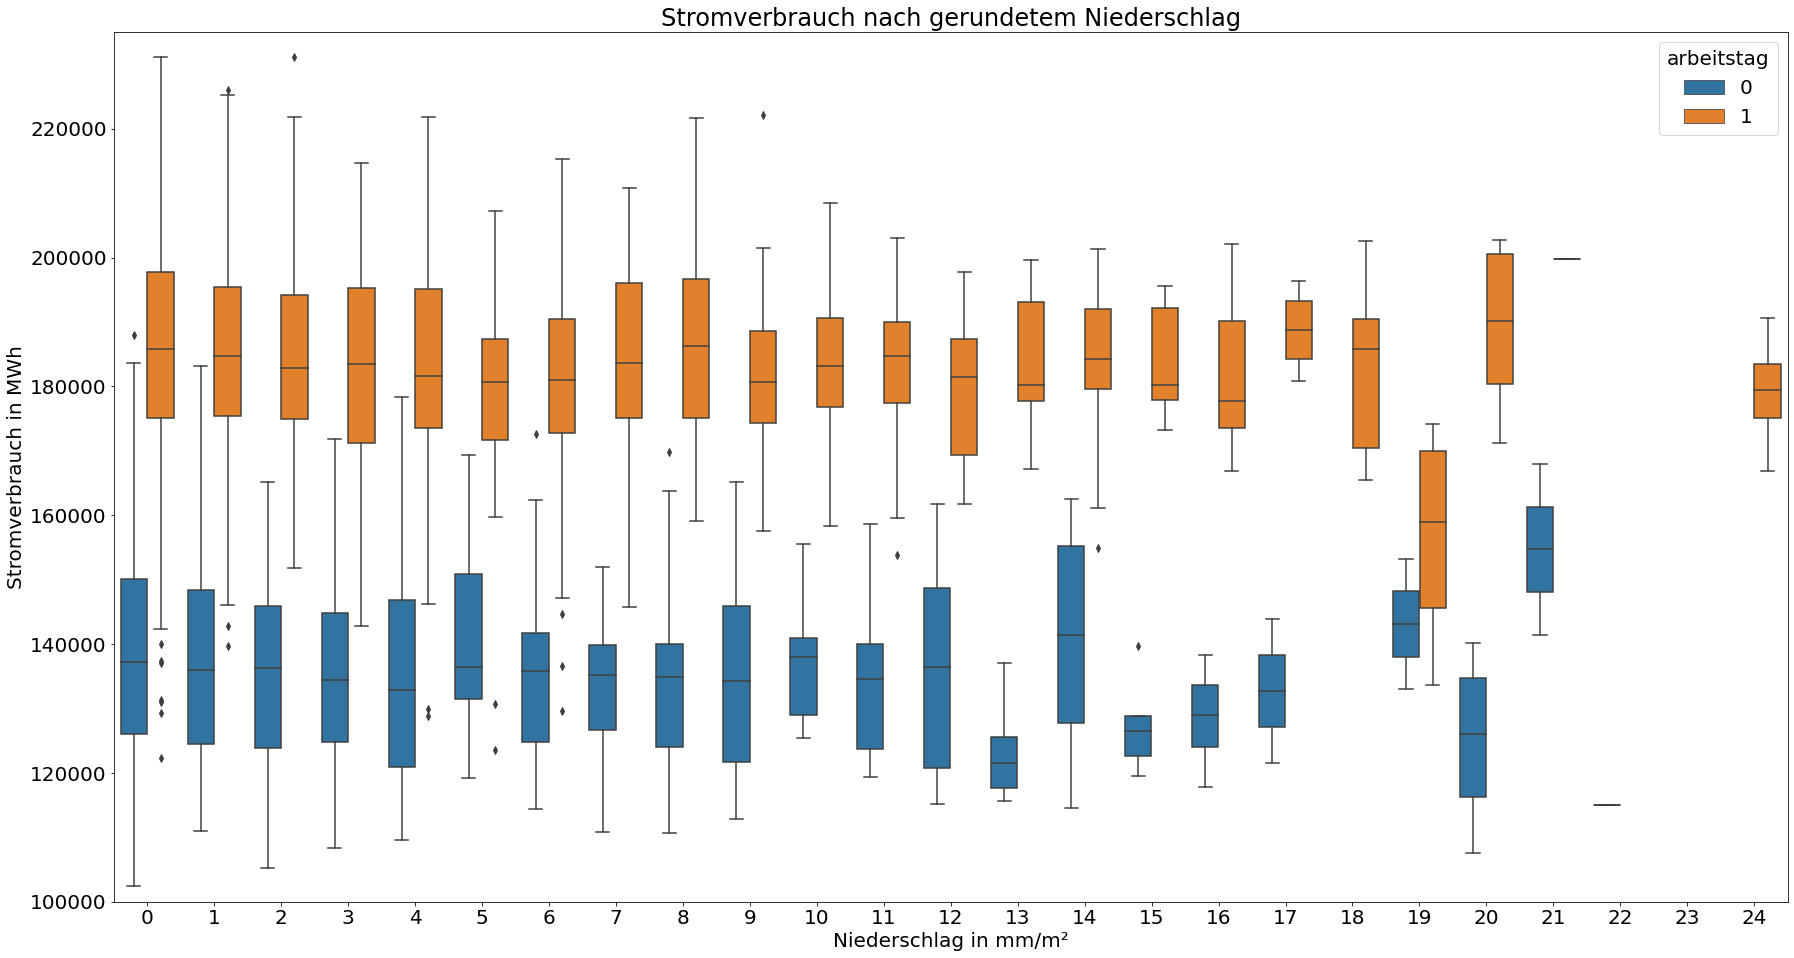

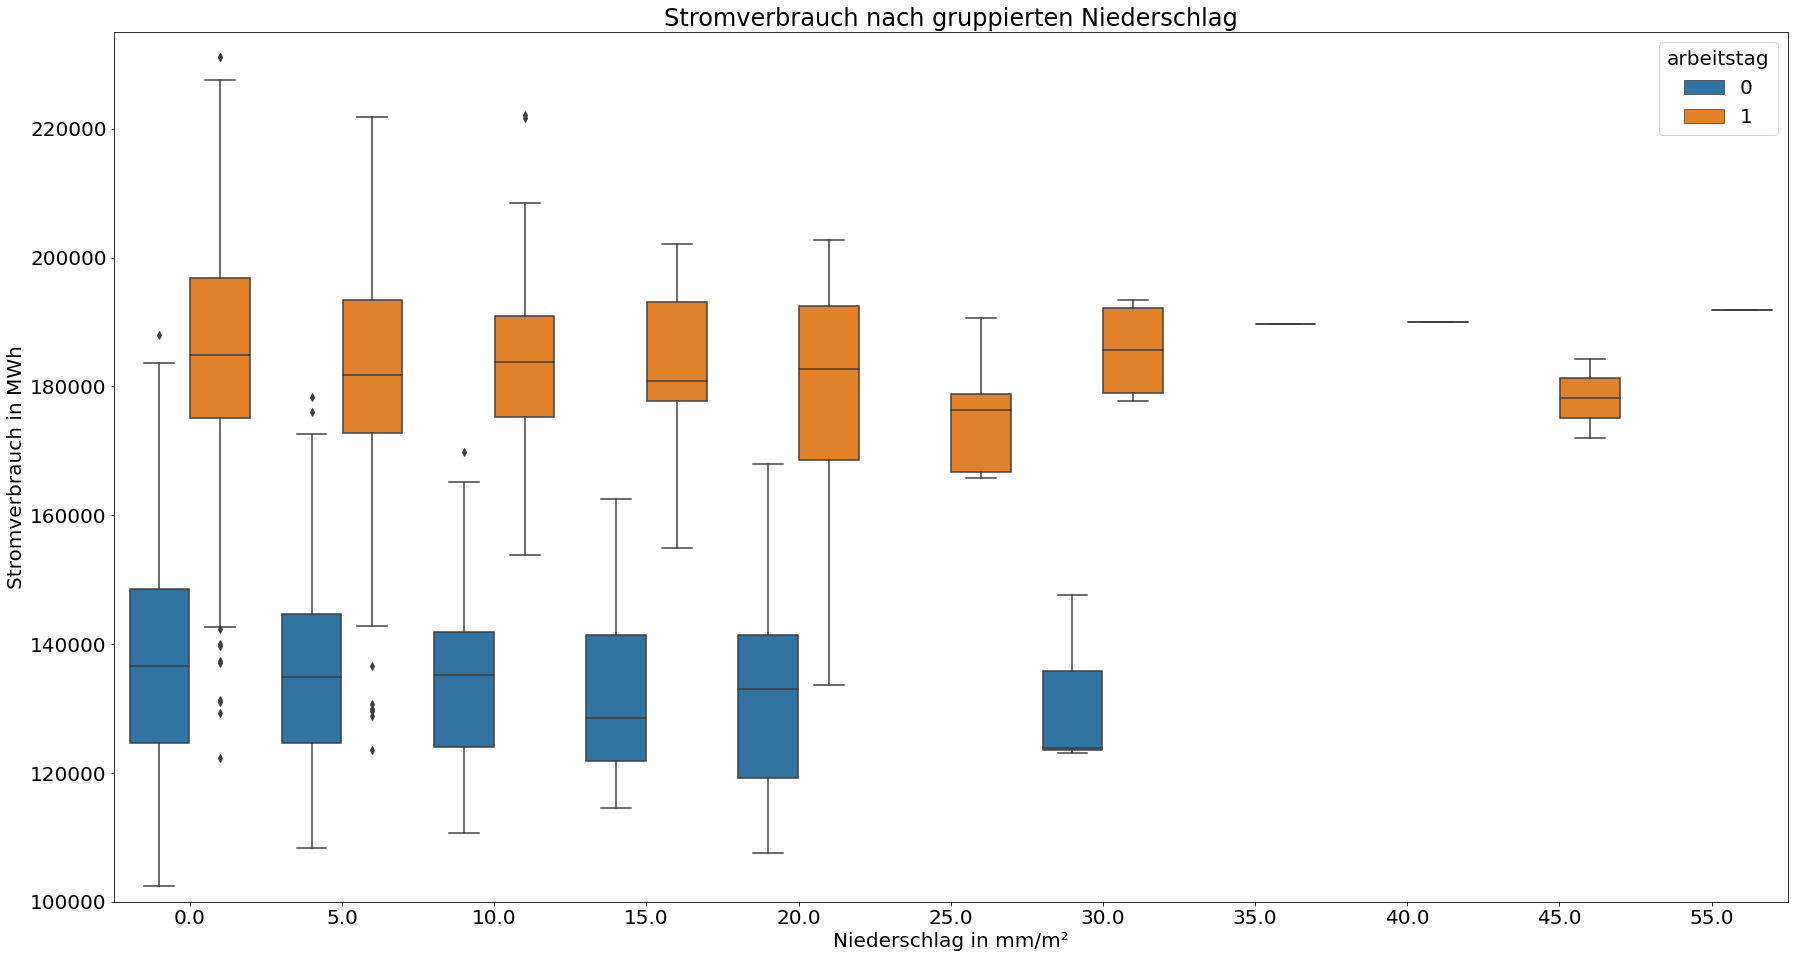

In [9]:
#Boxplot des gerundeten Niederschlags an Arbeitstagen erstellen
sns.boxplot(data=df, x="niederschlag_gerundet", y="verbrauch", hue="arbeitstag", order=np.arange(0, 57, 1))

#Achsen und Layout
plt.title("Stromverbrauch nach gerundetem Niederschlag")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Niederschlag in mm/m²")
plt.xticks(np.arange(0, 57, 1))

plt.show()

#Boxplot des gerundeten Niederschlags an Arbeitstagen erstellen
sns.boxplot(data=df, x="niederschlag_gerundet", y="verbrauch", hue="arbeitstag", order=np.arange(0, 25, 1))

#Achsen und Layout
plt.title("Stromverbrauch nach gerundetem Niederschlag")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Niederschlag in mm/m²")
plt.xticks(np.arange(0, 25, 1))

plt.show()

#Boxplot des gruppierten Niederschlags an Arbeitstagen erstellen
sns.boxplot(data=df, x="niederschlag_gruppiert", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach gruppierten Niederschlag")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Niederschlag in mm/m²")

plt.show()

## <font size="6">Stromverbrauch nach Niederschlag und Temperatur (Scatterplot)</font>

<font size="5">Im Scatterplot wird der Stromverbrauch nach Niederschlag und Temperatur abgetragen. Hier zeigt sich zwar die deutliche Abhängigkeit des Stromverbrauchs von der Temperatur, allerdings scheint die Luftfeuchtigkeit keinen Einfluss auf den Verbrauch zu haben.</font>

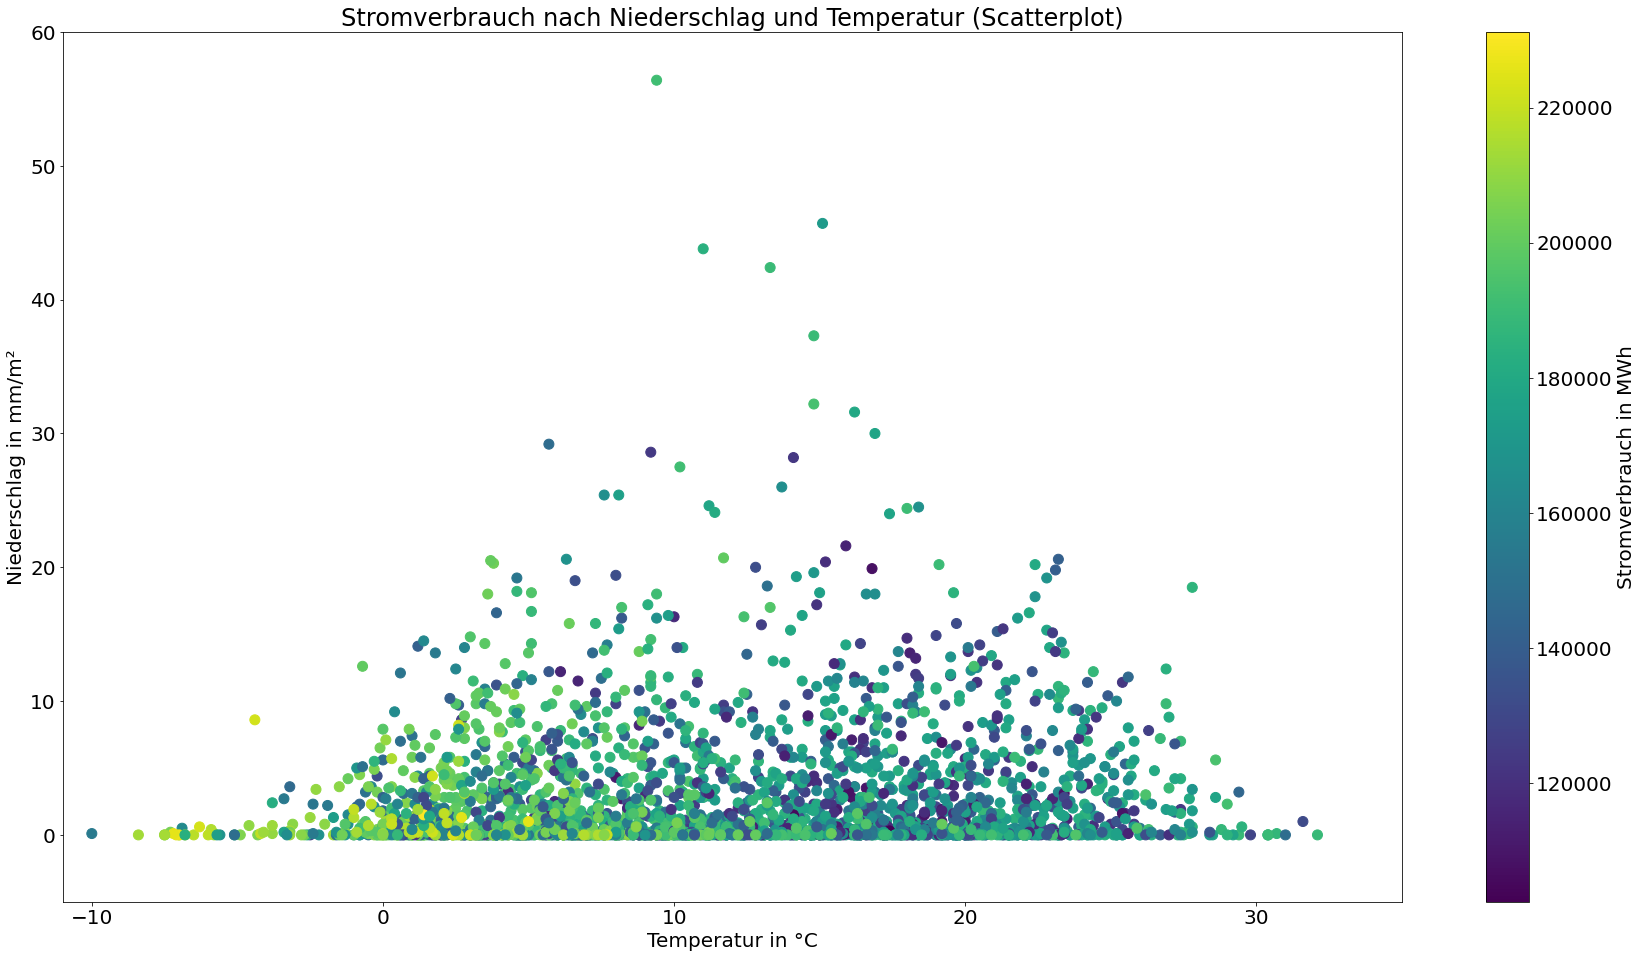

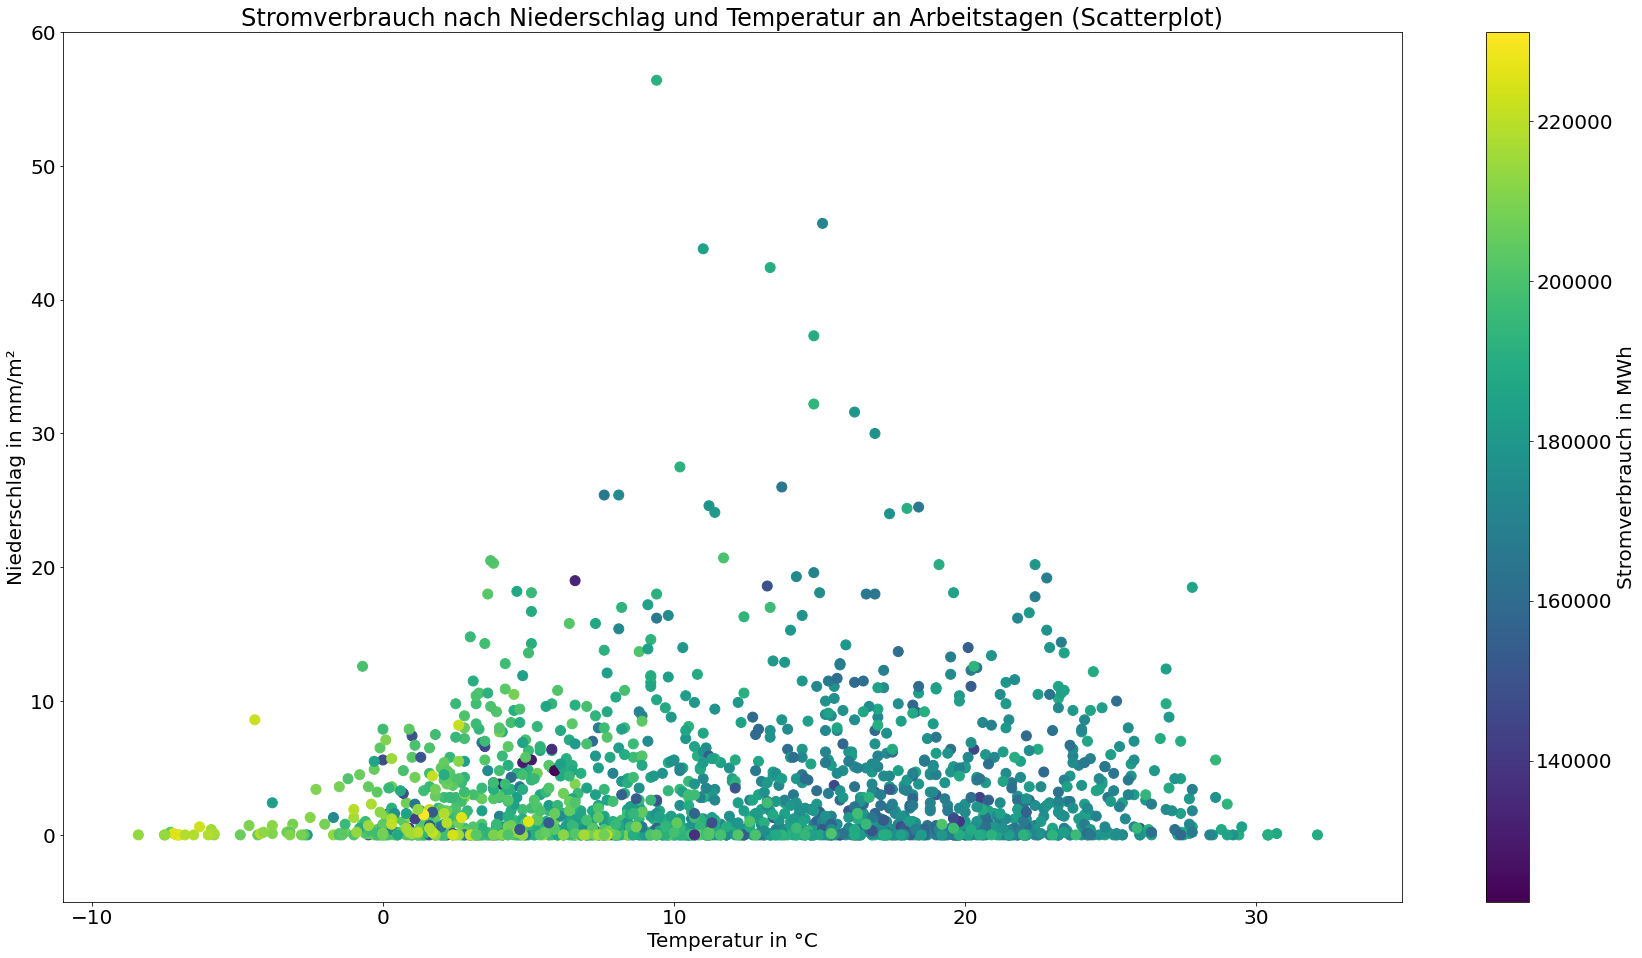

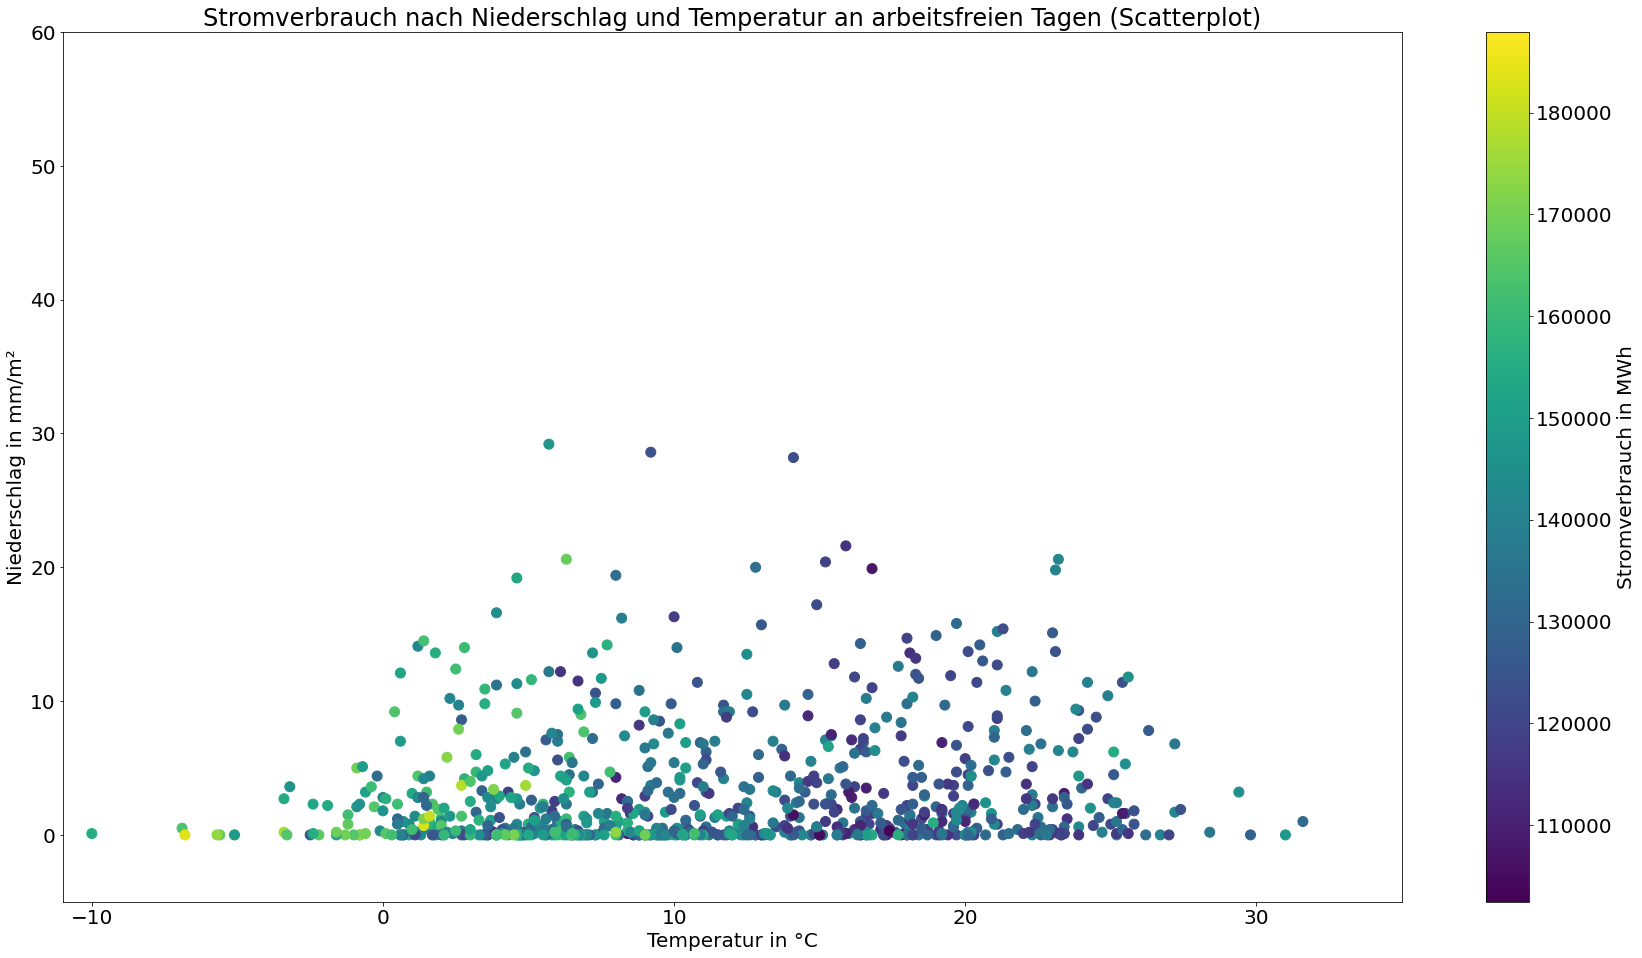

In [15]:
fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Niederschlag und Verbrauch an allen Tagen
scat = ax.scatter(df["temperatur"], df["niederschlag"], c=df["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Niederschlag und Temperatur (Scatterplot)")
ax.set_ylabel("Niederschlag in mm/m²")
ax.set_ylim(-5, 60)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Niederschlag und Verbrauch an Arbeitstagen
scat = ax.scatter(df_arbeitstag["temperatur"], df_arbeitstag["niederschlag"], c=df_arbeitstag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Niederschlag und Temperatur an Arbeitstagen (Scatterplot)")
ax.set_ylabel("Niederschlag in mm/m²")
ax.set_ylim(-5, 60)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Niederschlag und Verbrauch an arbeitsfreien Tagen
scat = ax.scatter(df_arbeitsfreiertag["temperatur"], df_arbeitsfreiertag["niederschlag"], c=df_arbeitsfreiertag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Niederschlag und Temperatur an arbeitsfreien Tagen (Scatterplot)")
ax.set_ylabel("Niederschlag in mm/m²")
ax.set_ylim(-5, 60)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

## <font size="6">Stromverbrauch nach Regen (Boxplot)</font><a class="anchor" id="2-06b-verrbauchnachregentagen"></a>

<font size="5">Bisher wurde der Niederschlag in mm/m² untersucht. Wird das Merkmal allerdings zusammengefasst in einem Indikator für Tage mit oder ohne Regen, dann lässt sich ebenfalls kein Unterschied erkennen. Für den Stromverbrauch ist der Niederschlag offensichtlich irrelevant.</font>

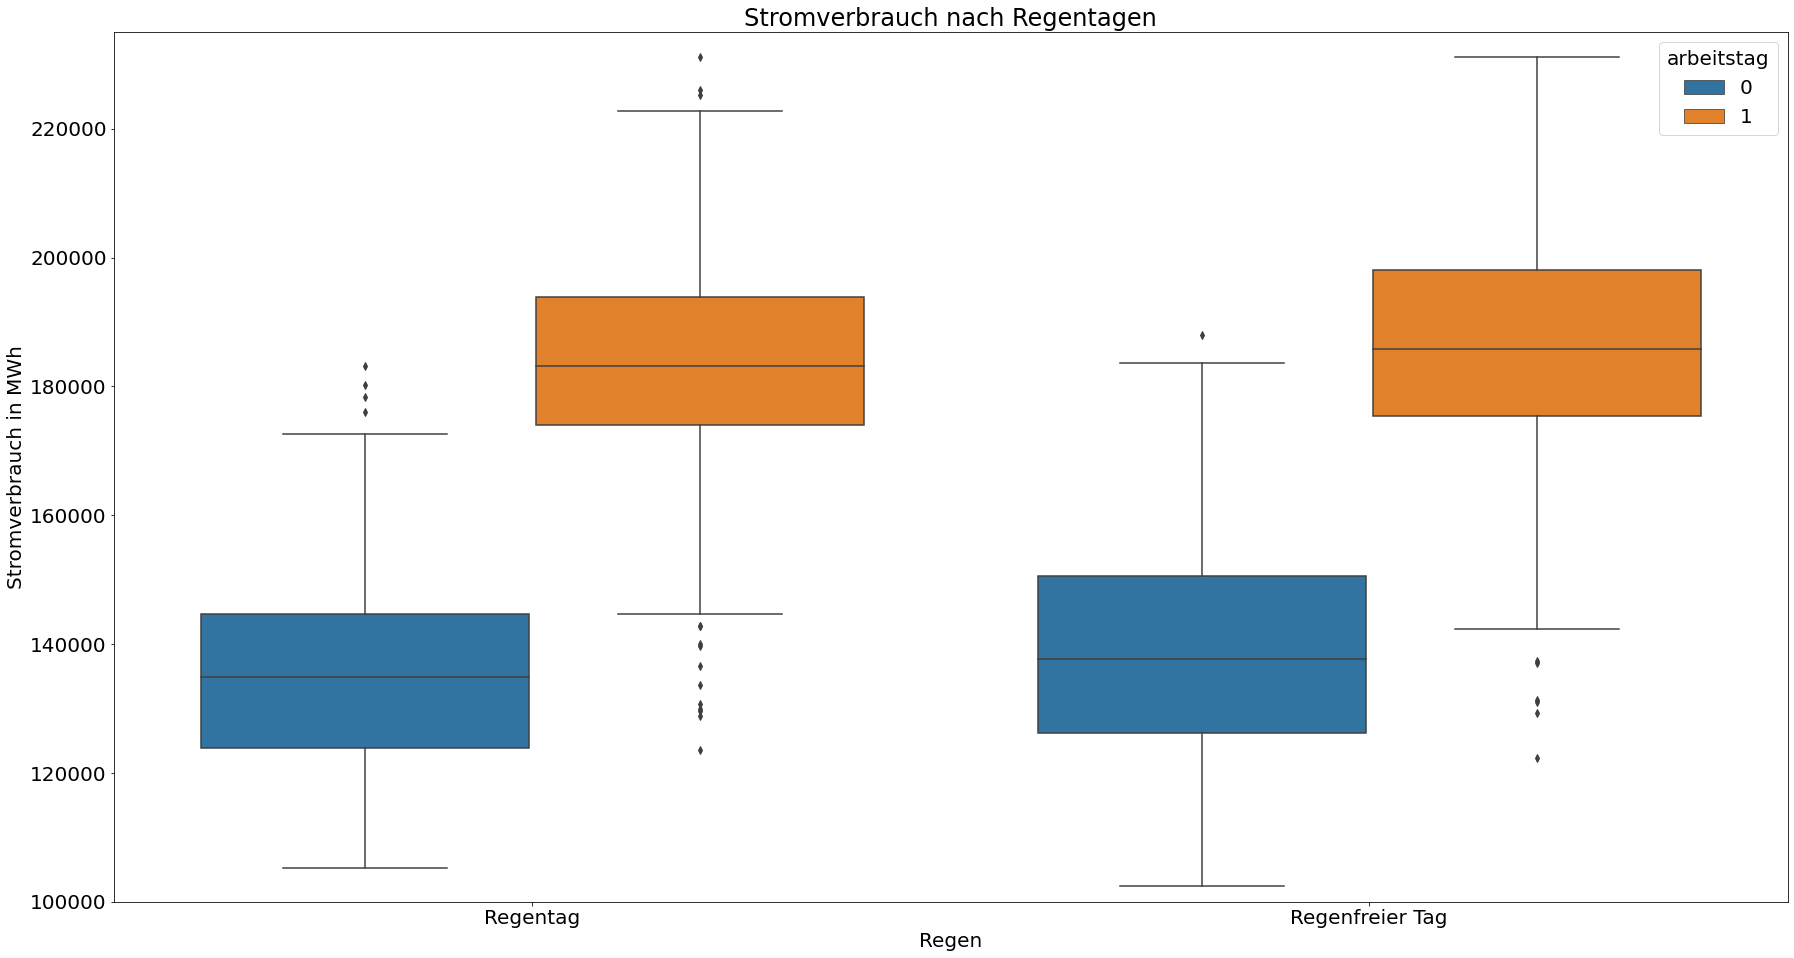

In [11]:
#Boxplot des gerundeten Niederschlags an Arbeitstagen erstellen
sns.boxplot(data=df, x="regen", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach Regentagen")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Regen")
plt.xticks([0, 1], ["Regentag", "Regenfreier Tag"])

plt.show()

# <font size="7">Regressionsanalyse</font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Niederschlag</font>

<font size="5">Das Regressionsmodell kann den Verlauf des Stromverbrauchs offensichtlich nicht anhand des Niederschlags abbilden. Es lässt sich nicht einmal die jährliche Saisonalität erfassen.</font>

            verbrauch  niederschlag
datum                              
2015-01-01   126197.0           0.0
2015-01-02   147085.0           5.6
2015-01-03   141426.0          14.1
2015-01-04   132446.0           4.4
2015-01-05   152611.0           0.0
...               ...           ...
2019-12-27   129551.0           5.6
2019-12-28   125395.0           0.0
2019-12-29   121331.0           0.0
2019-12-30   137130.0           0.0
2019-12-31   131060.0           0.0

[1826 rows x 2 columns]
       Vorhersage
R2           -0.0
MAE       21593.3
MSE   708597932.3
RMSE      26619.5
                 
MAPE       14.6 %


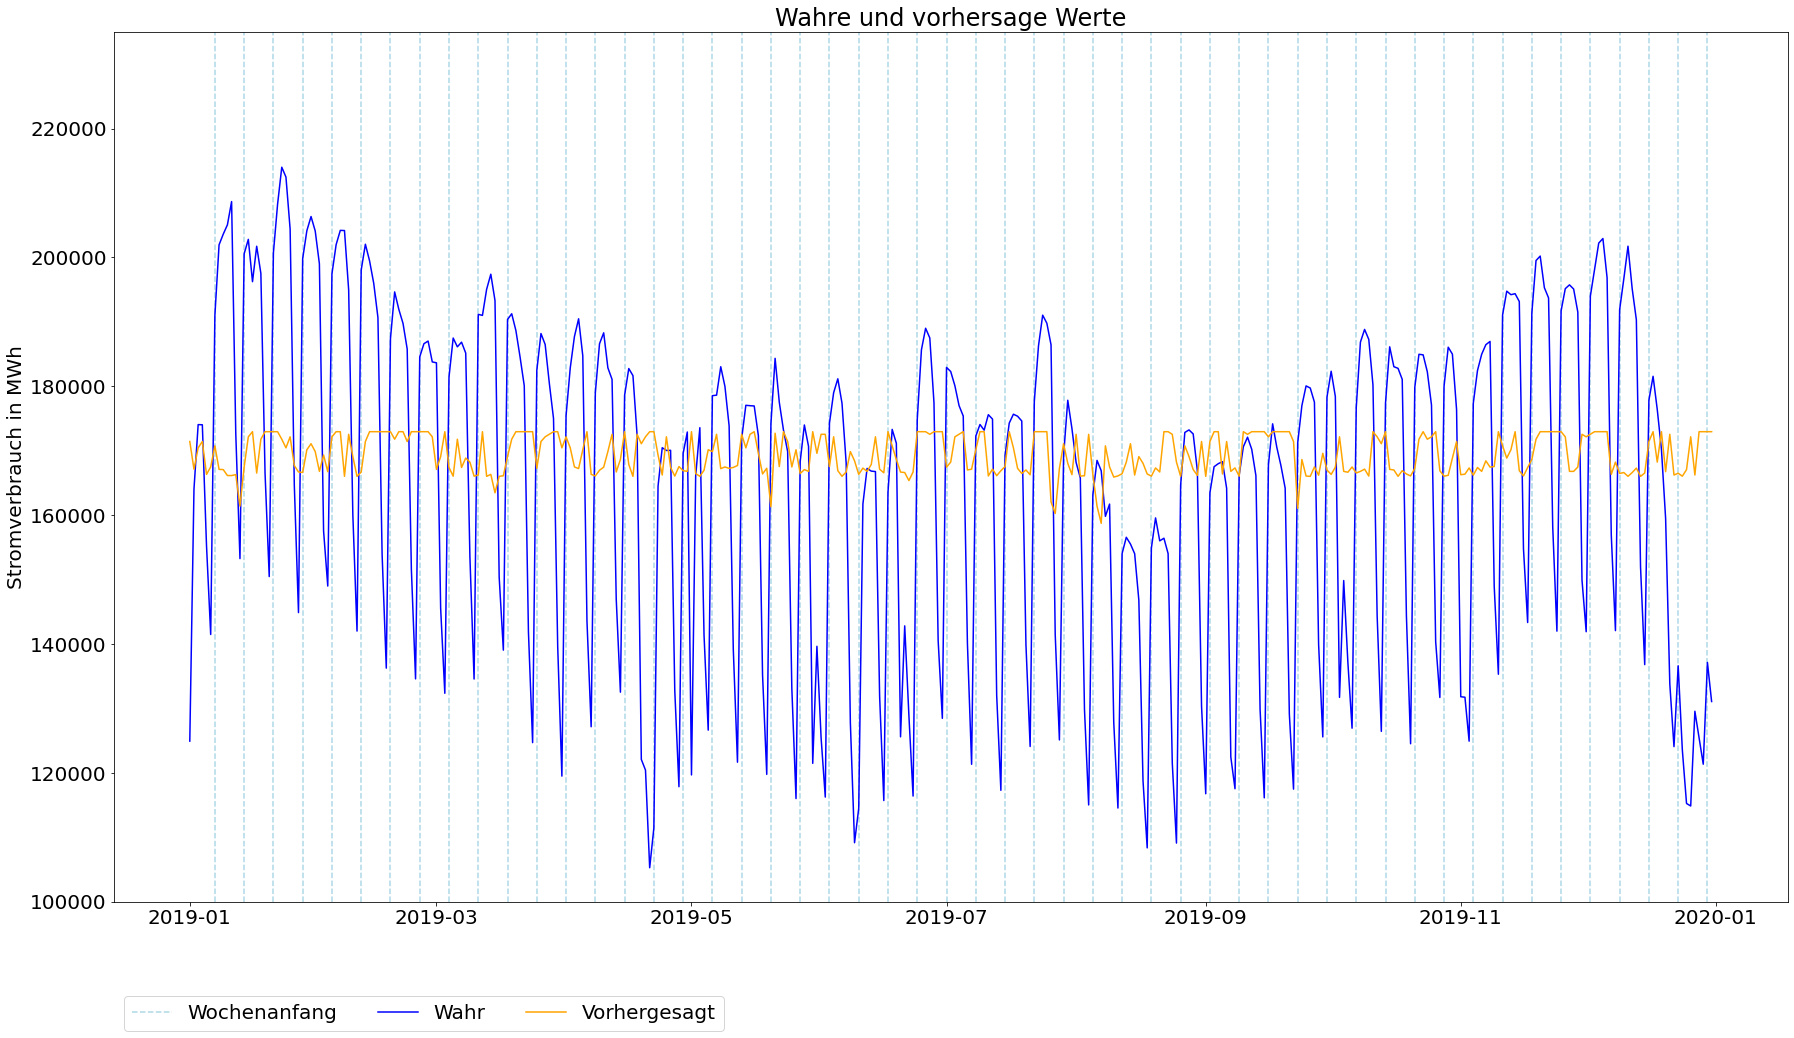

In [12]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["niederschlag"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["niederschlag"]].values.reshape(-1, 1))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["niederschlag"]])
X_test = pf.transform(test[["niederschlag"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstag und Niederschlag</font>

<font size="5">Wird das Modell zusätzlich mit den Arbeitstagen erweitert, zeigt sich ein ähnliches Verhalten wie bei der Luftfeuchtigkeit. Das Modell kann aufgrund des Indikator für Arbeitstage zwar die wöchentliche Saisonalität erfassen, die Luftfeuchtigkeit bring jedoch keine zusätzlichen Informationen.</font>

            verbrauch  arbeitstag  niederschlag
datum                                          
2015-01-01   126197.0         0.0           0.0
2015-01-02   147085.0         1.0           5.6
2015-01-03   141426.0         0.0          14.1
2015-01-04   132446.0         0.0           4.4
2015-01-05   152611.0         1.0           0.0
...               ...         ...           ...
2019-12-27   129551.0         1.0           5.6
2019-12-28   125395.0         0.0           0.0
2019-12-29   121331.0         0.0           0.0
2019-12-30   137130.0         1.0           0.0
2019-12-31   131060.0         1.0           0.0

[1826 rows x 3 columns]
       Vorhersage
R2            0.7
MAE       12122.7
MSE   235326242.0
RMSE      15340.3
                 
MAPE        7.8 %


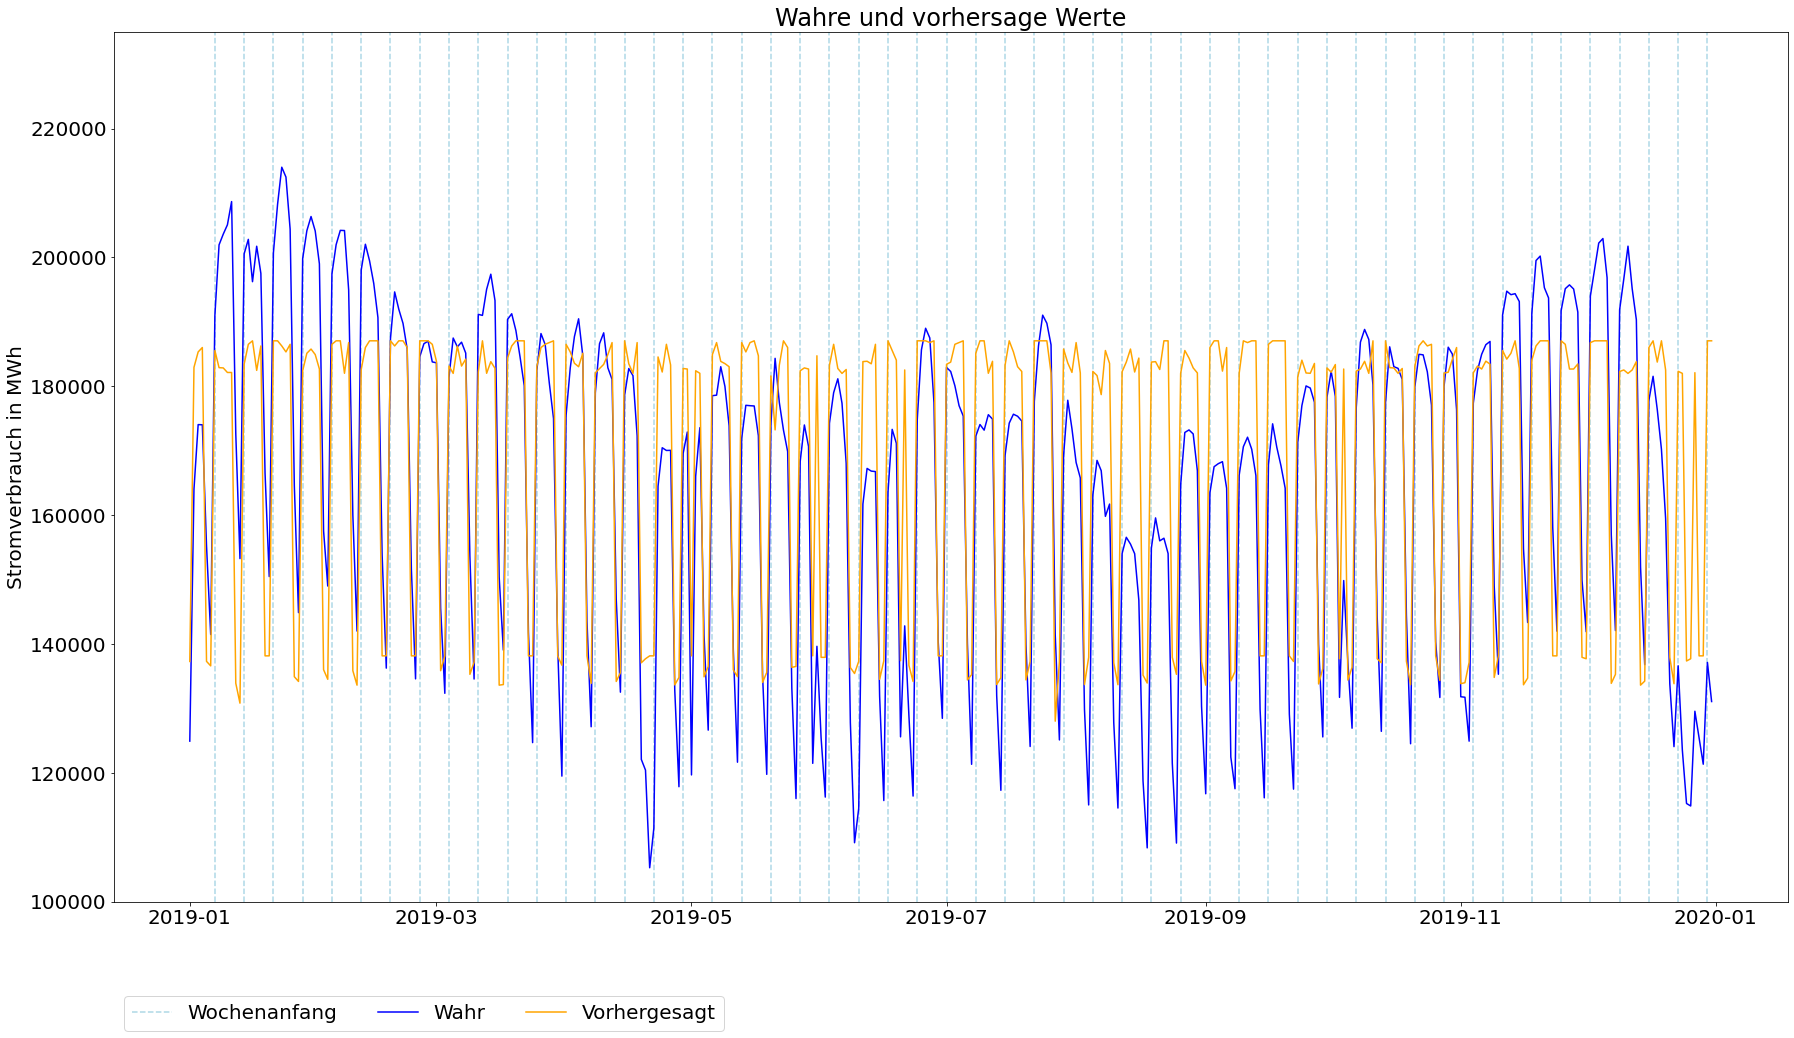

In [13]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["niederschlag"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "niederschlag"]].values.reshape(-2, 2))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "niederschlag"]])
X_test = pf.transform(test[["arbeitstag", "niederschlag"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstagen, Temperatur, Tagesstunden und Niederschlag</font>

<font size="5">Der Niederschlag führt ähnlich wie die Luftfeuchtigkeit ebenfalls zu einer Verschlechterung, wenn es den aussagekräftigen Merkmalen hinzugefügt wird.</font>

            verbrauch  tagesstunden  arbeitstag  temperatur  niederschlag
datum                                                                    
2015-01-01   126197.0           8.4         0.0        -2.5           0.0
2015-01-02   147085.0           8.4         1.0        -0.0           5.6
2015-01-03   141426.0           8.4         0.0         1.2          14.1
2015-01-04   132446.0           8.4         0.0        -0.2           4.4
2015-01-05   152611.0           8.4         1.0        -0.5           0.0
...               ...           ...         ...         ...           ...
2019-12-27   129551.0           8.3         1.0         5.1           5.6
2019-12-28   125395.0           8.3         0.0         1.7           0.0
2019-12-29   121331.0           8.3         0.0         1.1           0.0
2019-12-30   137130.0           8.3         1.0         2.8           0.0
2019-12-31   131060.0           8.3         1.0         3.2           0.0

[1826 rows x 5 columns]
       Vorher

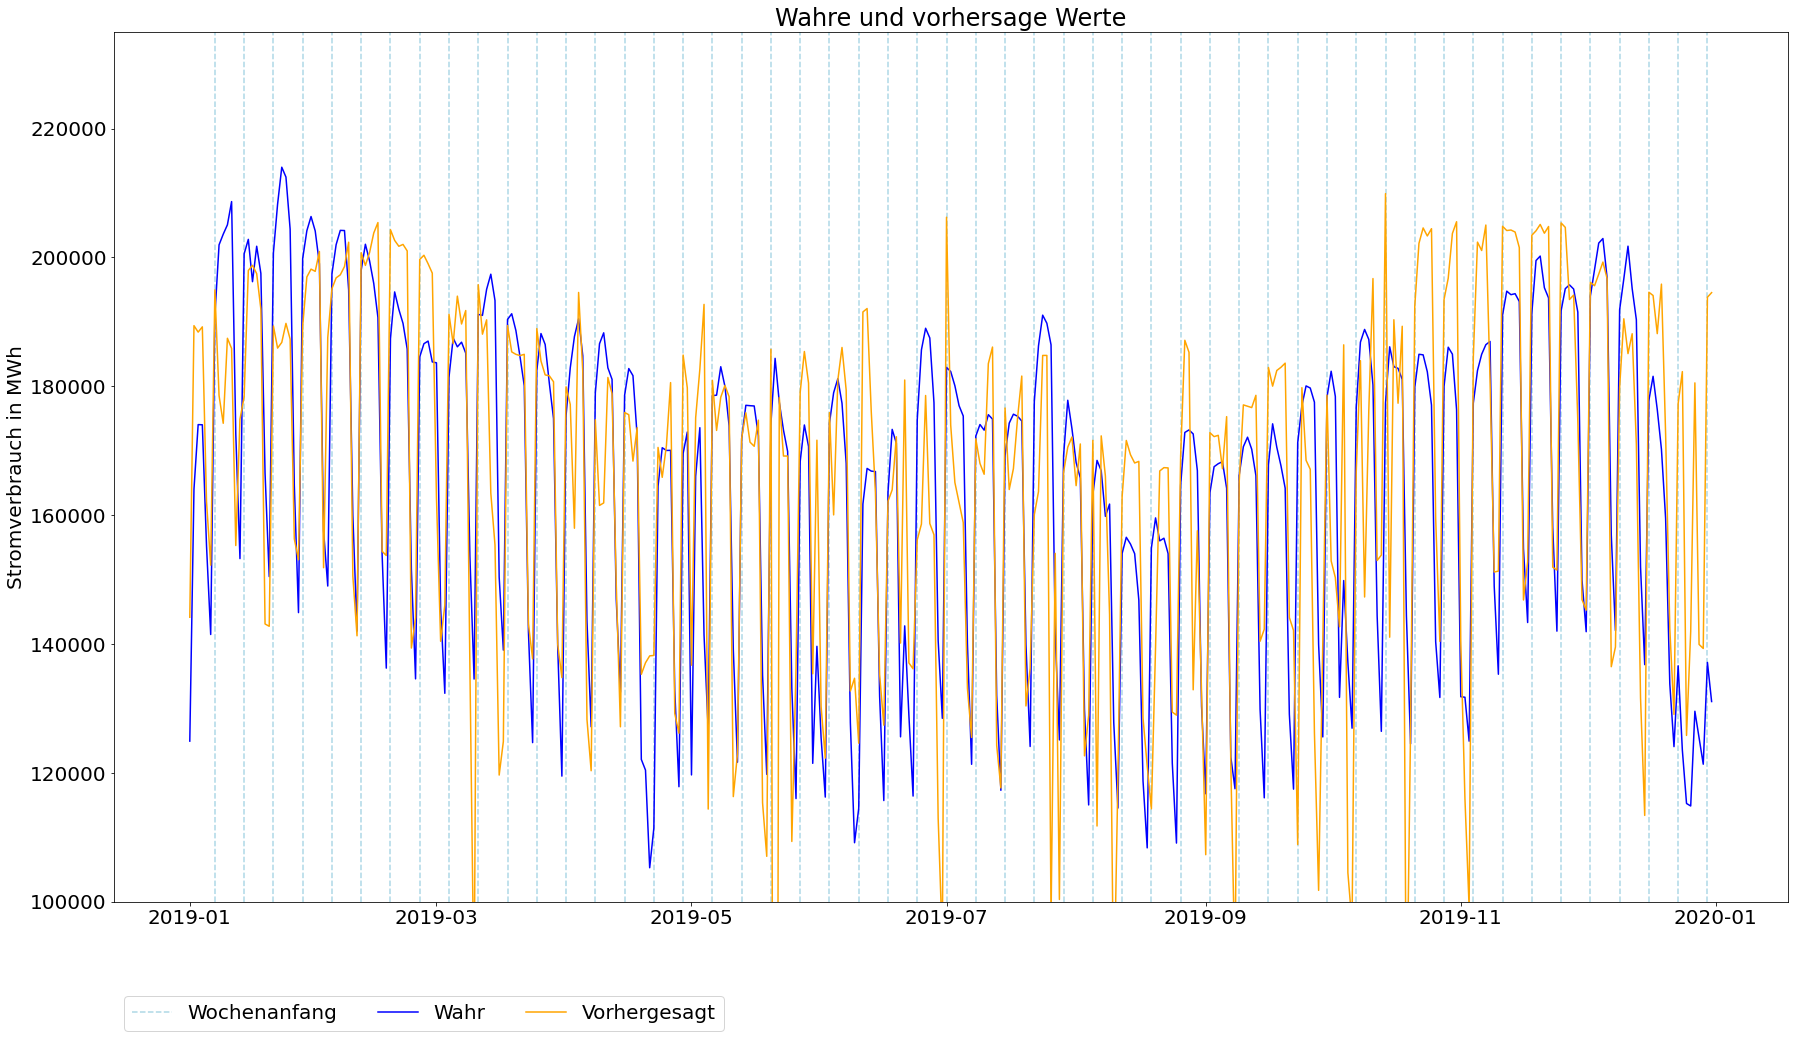

In [14]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["tagesstunden"], df["arbeitstag"], df["temperatur"], df["niederschlag"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=4)
pf = pf.fit(df_regression[["tagesstunden", "arbeitstag", "temperatur", "niederschlag"]].values.reshape(-4, 4))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["tagesstunden", "arbeitstag", "temperatur", "niederschlag"]])
X_test = pf.transform(test[["tagesstunden", "arbeitstag", "temperatur", "niederschlag"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)